In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import random

from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
!pip install seaborn
import seaborn as sns
# Define data loaders
from torch.utils.data import DataLoader, random_split,  Subset
import copy
import pickle
# torch.backends.nnpack.enabled = False

# Define preprocessing transformations
import os
!pip install torchviz
from torchviz import make_dot
seed=18
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Model architecture for training MNIST

In [11]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 1 input channel, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)  # 32 input channels, 32 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)  # 32 input channels, 64 output channels, 3x3 kernel
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)  # 64 input channels, 64 output channels, 3x3 kernel
        
        # Define max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling with stride 2
        
        # Define global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        
        # Define fully connected layer
        self.fc = nn.Linear(64, 10)  # 64 input features, 10 output classes

    def forward(self, x):
        # Apply convolution and ReLU activation
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        # Apply max pooling
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        # Apply global average pooling
        x = self.global_pool(x)
        # Flatten for fully connected layer
        x = x.view(-1, 64)
        # Fully connected layer
        x = self.fc(x)
        return x
	    
    def log_prob(self, x):
        # Compute the logits using the forward pass
        logits = self.forward(x)
        # Compute the log probability using softmax and log
        log_probabilities = F.log_softmax(logits, dim=1) # torch.nn.functional
        return log_probabilities

In [12]:
# Create an instance of the model
model = MNIST_CNN()

# Dummy input
dummy_input = torch.rand(1, 1, 28, 28)

# Create a graph of the model
graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save the graph to a file
graph.render("MNIST_CNN_model", format="png")

'MNIST_CNN_model.png'

### Function used for training the model:

In [13]:
def train_with_early_stopping(trainloader, valloader, testloader, model, optimizer, criterion, patience=5):
    best_val_accuracy = 0
    no_improvement_counter = 0

    for epoch in range(100):  # Maximum of 100 epochs
        # Train the model
        model.train()
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for inputs, labels in valloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1) # torch.max returns both the maximum values and their indices
                val_predictions.extend(predicted.numpy())
                val_true_labels.extend(labels.numpy())

        # Calculate validation accuracy
        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        print(f"Epoch {epoch + 1}: Validation Accuracy: {val_accuracy}")

        # Check for improvement in validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break

    # Evaluate on the test set after training
    model.eval()
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for inputs, labels in testloader: # batch wise for loop. 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.numpy())
            test_true_labels.extend(labels.numpy())

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    print(f"Test Accuracy: {test_accuracy}")

    return test_accuracy

### Loading MNIST data
We use only a 3000 size trainset to make the problem more challenging

In [14]:
# Define the root directory for data
data_root = './data'

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])

# Check if MNIST dataset is already downloaded, if not, download it
if not os.path.exists(os.path.join(data_root, 'MNIST')):
    mnist_trainset = torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
    mnist_testset = torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform=transform)
else:
    mnist_trainset = torchvision.datasets.MNIST(root=data_root, train=True, download=False, transform=transform)
    mnist_testset = torchvision.datasets.MNIST(root=data_root, train=False, download=False, transform=transform)

def stratified_sample(dataset, n_samples_per_class):
    labels = dataset.targets.numpy()
    classes = np.unique(labels)
    
    selected_indices = []
    for cls in classes:
        cls_indices = np.where(labels == cls)[0]
        selected_cls_indices = np.random.choice(cls_indices, size=n_samples_per_class, replace=False)
        selected_indices.extend(selected_cls_indices)
    
    return selected_indices
n_samples_per_class = 300
selected_indices = stratified_sample(mnist_trainset, n_samples_per_class)
mnist_trainset = torch.utils.data.Subset(mnist_trainset, selected_indices)
# Initialize models and optimizer
mnist_model = MNIST_CNN()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss() # multiclassification- also needed for FGSM attack 
train_size_mnist = int(0.9 * len(mnist_trainset))
print(len(mnist_trainset))
indices = torch.randperm(len(mnist_trainset)).tolist()
train_indices, val_indices = indices[:train_size_mnist], indices[train_size_mnist:]
# Create subsets of the list and the dataset
mnist_valset = torch.utils.data.Subset(mnist_trainset, val_indices)
mnist_trainset = torch.utils.data.Subset(mnist_trainset, train_indices)
# Define data loaders for training, validation, and testing
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_valloader = DataLoader(mnist_valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

3000


### Visualization of poisoning methods:

1) Annotation noise<br>
2) Random Input noise <br>
3) Adversarial poisoning<br>

1) Adding label noise to the dataset: Using an example confusion matrix as defined in the paper 

In [15]:
# MNIST confusion matrix
# Initialize a 10x10 confusion matrix with ones on the diagonal
mnist_cm = np.eye(10)
# Set misclassification probabilities
mnist_cm[1, 1] = 0.6 
mnist_cm[7, 7] = 0.6  
mnist_cm[1, 7] = 0.4  # Probability of misclassifying label 1 as label 7
mnist_cm[7, 1] = 0.4  # Probability of misclassifying label 7 as label 1
mnist_cm[6, 6] = 0.7  
mnist_cm[9, 9] = 0.7  
mnist_cm[6, 9] = 0.3  # Probability of misclassifying label 6 as label 9
mnist_cm[9, 6] = 0.3  # Probability of misclassifying label 9 as label 6
print(mnist_cm)

[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.  0.  0.  0.  0.4 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.3]
 [0.  0.4 0.  0.  0.  0.  0.  0.6 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.  0.  0.7]]


In [16]:
def flip_labels(dataloader, cm):
    noisy_labels = []
    misclassifcn_dict= {i: 0 for i in range(10)}
    for _, labels in dataloader:
        for label in labels:
            # Randomly flip the label according to the confusion matrix
            noisy_label = np.random.choice(np.arange(len(cm)), p=cm[label])
            if(noisy_label!=label):
                # print(label.shape, label)
                misclassifcn_dict[int(label.numpy())]+=1 # label is a tensor so conversion is needed to access dict keys
            noisy_labels.append(noisy_label)
						
    return noisy_labels, misclassifcn_dict

# Apply noise to the training labels
noisy_mnist_labels, missclassfcn_dict = flip_labels(mnist_testloader, mnist_cm)
# using these noisy labels will be equivalent to adding annotation noise
print(len(noisy_mnist_labels))
print(missclassfcn_dict)

10000
{0: 0, 1: 435, 2: 0, 3: 0, 4: 0, 5: 0, 6: 292, 7: 418, 8: 0, 9: 300}


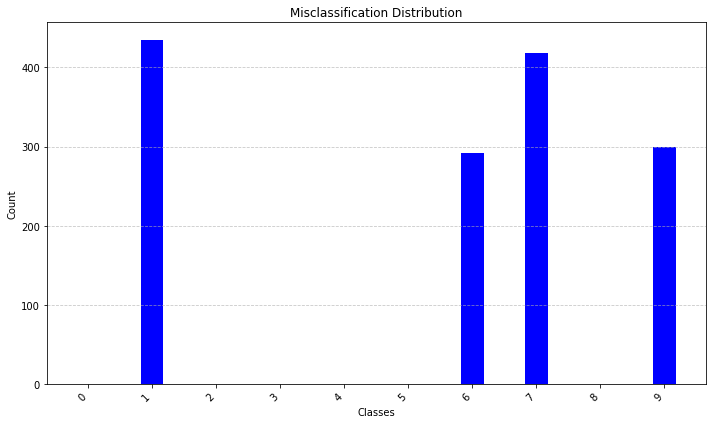

In [17]:
def plot_histogram(misclassfcn_dict, label_names=None):
    if label_names is None:
        label_names = [str(i) for i in range(10)]
    plt.figure(figsize=(10, 6))
    bins = np.arange(len(label_names) + 1)  # Define bin edges
    width = 0.35  # Width of each bar
    for idx, (label, freq) in enumerate(misclassfcn_dict.items()):
        plt.bar(idx, freq, width, label=label_names[label], color='blue')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Misclassification Distribution')
    plt.xticks(np.arange(len(label_names)), label_names, rotation=45, ha='right')
    # plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot histogram
plot_histogram(misclassfcn_dict=missclassfcn_dict)

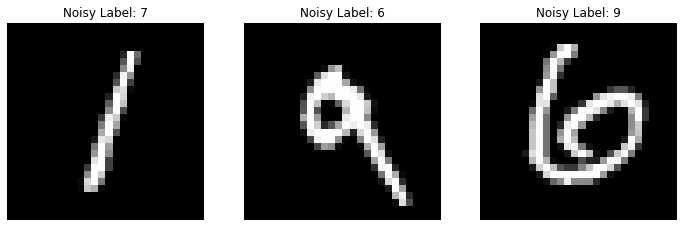

In [18]:
# Define a function to display images with labels
def display_images_with_noisy_labels(test_loader, noisy_labels, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    count = 0
    for images, labels in test_loader:
        for i in range(len(images)):
            if labels[i] != noisy_labels[i] and count < num_images:
                axes[count].imshow(images[i].squeeze(), cmap='gray')
                axes[count].set_title(f'Noisy Label: {noisy_labels[i]}')
                axes[count].axis('off')
                count += 1
    plt.show()

# Display the images with their noisy labels
display_images_with_noisy_labels(mnist_testloader, noisy_mnist_labels, num_images=3)

In [19]:
# Define the root directory for data
data_root = './data'
# Define preprocessing transformations
transform1 = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

mnist_trainset1 = torchvision.datasets.MNIST(root=data_root, train=True, download=False, transform=transform1)
mnist_testset1 = torchvision.datasets.MNIST(root=data_root, train=False, download=False, transform=transform1)


2) Random input noise

Label: 7)


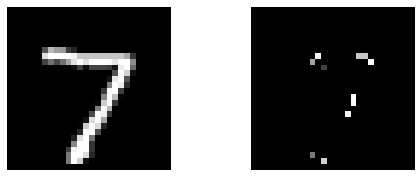

Label: 1)


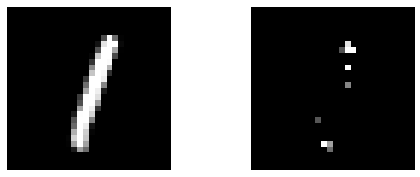

In [20]:
# inages of both the datasets are constrained between 0 and 1, with 0 meaning black. 
def input_noise(dataset, classes, gamma=0.3, mode="Gaussian", num_examples=2):
    assert mode in ["Salt and Pepper", "Gaussian"], "Mode must be either 'Salt and Pepper' or 'Gaussian'"
    assert 0 <= gamma <= 1, "Gamma must be in the range [0, 1]"
    noisy_images = []
    bar = 0
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        if label in classes:
                temp = image.clone()  # Create a copy of the image tensor
                noisy_image = None
                if np.random.rand() < gamma:  # Apply noise with probability gamma
                    if mode == "Salt and Pepper":
                        noisy_image = add_salt_and_pepper_noise(temp)
                    elif mode == "Gaussian":
                        noisy_image = add_gaussian_noise(temp)
                    if bar < num_examples:
                        # Print the original and noisy images for a few examples
                        print("Label: {})".format(label))
                        show_images_in_one_row(temp, noisy_image)
                        bar += 1
                else:
                    noisy_image = temp
        else:
                temp = image
                noisy_image = temp
                
        noisy_images.append(noisy_image)
    return noisy_images

def add_salt_and_pepper_noise(image):
    noisy_image = image.clone()
    mask = torch.rand_like(image) < 0.9 # Salt and pepper noise with equal probability
    noisy_image[mask] = 0
    return noisy_image

def add_gaussian_noise(image):
    noisy_image = image.clone()
    noise = torch.randn_like(image) # Standard deviation of 25 for Gaussian noise
    noisy_image += noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

def show_images_in_one_row(image1, image2):
    plt.figure(figsize=(8, 3))
    if image1.shape[0] == 3:  # RGB image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.permute(1, 2, 0))  # Permute to move channel dimension to the last
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.permute(1, 2, 0))
        plt.axis('off')
    else:  # Grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

noisy_images = input_noise(mnist_testset1, [1, 7, 6, 9], gamma=0.4, mode="Salt and Pepper", num_examples=2)

3) Adversarial attack using FGSM

FGSM: fast gradient sign method attack, which is a white box attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. Gradients are taken with respect to the input image. <br>
$adv_x = x + \epsilon * \text{sign}(\nabla_x J(\theta, x, y))$
where:<br>
- $adv_x$: Adversarial image.
- x: Original input image.
- y: Original input label.
- $\epsilon$: Multiplier to ensure the perturbations are small.
- $\theta$: Model parameters.
- J: Loss.

A small perturbation is added to the original input image x in the direction that maximizes the loss function J, subject to a constraint controlled by the multiplier $\epsilon$. (for more details see [here](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm))


Original (Label: 1)


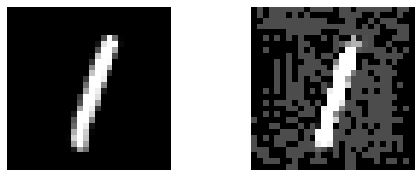

Original (Label: 9)


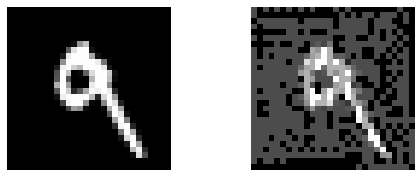

Original (Label: 9)


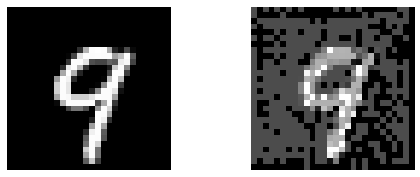

In [21]:
# Function to craft adversarial examples using FGSM
def fgsm_attack(model, image, label, epsilon=0.1):
    image.requires_grad = True # need to store gradients of images 
    # print(image.shape) (1, 28, 28)
    image1= image.unsqueeze(0)
    # print(image1.shape) (1, 1, 28, 28)
    label1= torch.tensor(label).unsqueeze(0) # label is initially an integer, need to convert to tensor before passing to loss. 
    # print(label1.shape)
    outputs = model(image1) # This is a probability distribution over the ten classes, needed for loss
    loss = criterion(outputs, label1)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    noise=  epsilon * torch.sign(data_grad)
    perturbed_image = image + noise
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Clip perturbed data to [0, 1] range
    perturbed_label= int(model(perturbed_image.unsqueeze(0)).argmax(1)) # find the label predicted for the adversarial image. 
    image.requires_grad = False # detaching from gradient calculation
    # perturbed_image.requires_grad = False : cannot be done, only leaf nodes can be attached/detached
    return image, noise, perturbed_image, perturbed_label


# Function to apply adversarial perturbations to create new poisoned data
def adversarial_poisoning(dataset, classes, victim_model, epsilon=0.2, contamination_rate=0.3, num_examples= 3):
    poisoned_data = []
    bar= 0
    dataset_new= copy.deepcopy(dataset) # operate on a clone of the images. 
    for idx in range(len(dataset_new)): #batchwise loop
        image, label= dataset_new[idx]
        if label in classes and np.random.rand()<contamination_rate:	#contaminate from the given classes with a probability 0.3
            image, noise, perturbed_image, perturbed_label = fgsm_attack(victim_model, image, label, epsilon)  # images are cloned. 
            if bar < num_examples:
                        # Print the original and noisy images for a few examples
                        print("Original (Label: {})".format(label))
                        show_images_in_one_row(image, perturbed_image)
                        bar += 1
            poisoned_data.append((perturbed_image, label))
    return poisoned_data


def show_images_in_one_row(image1, image2):
    # print(image1.shape, image2.shape)
    plt.figure(figsize=(8, 3))
    if image1.shape[0] == 3:  # RGB image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.permute(1, 2, 0))  # Permute to move channel dimension to the last
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.permute(1, 2, 0))
        plt.axis('off')
    else:  # Grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.detach().squeeze(), cmap='gray') # detach used because error in squeezing when we're still calculatiing grads? 
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.detach().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

poisoned_data = adversarial_poisoning(mnist_testset1, [1, 7, 6, 9], mnist_model, epsilon=0.3)

For cause identification, we need to find the failure set F on which the model is wrong in the test set. The function for that is given below

In [22]:
def create_failure_set(testloader, model, batch_size=64):
    # Evaluate on the test set after training
    model.eval()
    misclassified_inputs = []
    misclassified_labels = []
    correct_inputs=[]
    correct_labels=[]
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            misclassified_mask = predicted != labels
            misclassified_inputs.append(inputs[misclassified_mask])
            misclassified_labels.append(labels[misclassified_mask])
            correct_mask = predicted == labels
            correct_inputs.append(inputs[correct_mask])
            correct_labels.append(labels[correct_mask])

    misclassified_inputs = torch.cat(misclassified_inputs, dim=0)
    misclassified_labels = torch.cat(misclassified_labels, dim=0)
    correct_inputs = torch.cat(correct_inputs, dim=0)
    correct_labels = torch.cat(correct_labels, dim=0)
    failure_dataset = TensorDataset(misclassified_inputs, misclassified_labels)
    correct_dataset = TensorDataset(correct_inputs, correct_labels)
    failure_loader = DataLoader(failure_dataset, batch_size=batch_size, shuffle=True)
    print("The size of the failure set is ", len(failure_dataset))
    return failure_loader,failure_dataset,correct_dataset


The above code finds the failure set $\mathcal{F} ={(x^{(n)},y^{(n)})}^{N_f}_{n=1} $

### Cause identification 
The functions for finding the "failure causes" of bad performance by finding the "influence" of each training data point are now defined. So we look at 4 algos for cause identification: <br>
1) Linear influence- GD<br>
2) SGD influence<br>
3) EWC influence <br>

### Method 1: Cause identification: Linear influence 

They are used to answer the question: why did the model make a prediction? Which training points were most responsible for this prediction? Upweight and downwight contribution of each image by changing loss function. Upwieghting a training image means that the model will try a little harder to fit that particular image. 
https://www.youtube.com/watch?v=0w9fLX_T6tY&t=75s<br>
code: https://github.com/kohpangwei/influence-release

After observing the set of failures $ F $, a point estimate of $ p(\theta|D,F) $ is obtained by performing a single update of natural gradient ascent on the log likelihood of $ F $ with step size $ \gamma > 0 $: $ q^+(θ)=δ(θ−θ_{+F}) \approx p(θ|D,F)$

We are using the log likelihood of $\mathcal{F}$ given $\hat{\theta}$. 

In [23]:
def calc_FIM(train_set,trained_model,criterion):
    fim=None
    num_points = 100
    indices = np.arange(len(train_set))
    np.random.shuffle(indices)
    selected_indices = indices[:num_points]
    subset = torch.utils.data.Subset(train_set, selected_indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=True)
    for batch_idx, (input, target) in enumerate(subset_loader):
        input.requires_grad_(True)
        outputs = trained_model(input)
        loss = criterion(outputs, target)
        trained_model.zero_grad()
        loss.backward()
        gradient_input_data = []
        for name, param in trained_model.named_parameters():
            if param.requires_grad:
                gradient_input_data.append(param.grad.view(-1))
        flat_tensor = torch.cat(gradient_input_data, dim=0)
        if fim is None:
            fim=torch.mul(flat_tensor,flat_tensor)
        else:
            fim+=torch.mul(flat_tensor,flat_tensor)
    fim=fim/num_points
    return fim

In [24]:
def calc_pre_cal(failure_set,trained_model,criterion,fim,alpha):
    v=torch.zeros(fim.size(dim=0))
    f=torch.zeros(fim.size(dim=0))
    failure_set_loader = DataLoader(failure_set, batch_size=1, shuffle=True)
    for batch_idx, (input, target) in enumerate(failure_set_loader):
        outputs = trained_model(input)
        loss = criterion(outputs, target)
        trained_model.zero_grad()
        loss.backward()
        gradient_input_data = []
        for name, param in trained_model.named_parameters():
            if param.requires_grad:
                gradient_input_data.append(param.grad.view(-1))
        flat_tensor = -1*torch.cat(gradient_input_data, dim=0)
    count=0
    while True:
        v_new=v-alpha*(2*torch.mul(fim,v)-flat_tensor)
        if torch.norm(v_new-v)<1e-2 or count>1e6:
            break
        if count%40000==0:
            print("on the iteration ",count)
            print(torch.norm(v_new-v))
        count+=1
        v=v_new
    pre_cal=v
    return pre_cal

This function computes the influences r of the trainset

In [25]:
def linear_influence_function(train_set,trained_model,criterion,failure_set,gamma=0.01):
    print("Going to calculate FIM")
    fim=calc_FIM(train_set,trained_model,criterion)
    print("Done with FIM calculations")
    print(fim)
    print("Going for a minimisations of the pre-calculations")
    pre_cal=calc_pre_cal(failure_set,trained_model,criterion,fim,alpha=0.05)
    print("Done with pre-calculations")
    print(pre_cal)
    r=[]
    trainset_loader = DataLoader(train_set, batch_size=1, shuffle=False)
    for batch_idx, (input, target) in enumerate(trainset_loader):
        outputs = trained_model(input)
        loss = criterion(outputs, target)
        trained_model.zero_grad()
        loss.backward()
        gradient_input_data = []
        for name, param in trained_model.named_parameters():
            if param.requires_grad:
                gradient_input_data.append(param.grad.view(-1))
        flat_tensor = -1*torch.cat(gradient_input_data, dim=0)
        r.append(((input,target,train_indices[batch_idx]),-1*gamma*torch.matmul(pre_cal,flat_tensor)))
    return r

Function used to sort the influences and plot

In [26]:
def sort_key(pair):
    return -pair[1].item() 

In [27]:
mnist_model.load_state_dict(torch.load('mnist_model.pth'))

<All keys matched successfully>

### Computing FIM
An outer product is the tensor product of two vectors $ \mathbf{u} = [u_1, u_2, \ldots, u_m] $ and $ \mathbf{v} = [v_1, v_2, \ldots, v_n] $, denoted by $ \mathbf{u} \otimes \mathbf{v} $, is an $ m \times n $ matrix $ \mathbf{W} $ such that its coordinates satisfy $ w_{i,j} = u_i v_j^* $. The outer product $ \mathbf{u} \otimes \mathbf{v} $ is equivalent to a matrix multiplication $ \mathbf{u} \mathbf{v}^* $ (or $ \mathbf{u} \mathbf{v}^T $ if vectors are real) provided that $ \mathbf{u} $ is represented as a column $ m \times 1 $ vector, and $ \mathbf{v} $ as a column $ n \times 1 $ vector. Here $ v^* = \overline{v^T} $. So when we are calculating the emperical FIM, if we calculate the vector $ \mathbf{u}$ of gradients $\nabla_{\theta} \log p_{\theta}(y_n|x_n)$ and do the outer product with itself, we will get back $\tilde{F} = \sum_{n} [\nabla_{\theta} \log p_{\theta}(y_n|x_n) (\nabla_{\theta} \log p_{\theta}(y_n|x_n))^{\top}]$ of size n*n. The empirical Fisher Information Matrix (FIM) is an approximation of the true FIM, which is defined as the expected value of the outer product of the gradients of the log-likelihood function with respect to the parameters. The empirical FIM is computed by taking the sum of the Hessians of the negative log-likelihood function with respect to the parameters, evaluated at the data points.

In [28]:
def compute_fisher_information(model, dataset):
    fisher_information = 0
    for x, y in tqdm(dataset, desc="Computing Fisher Information"):
        model.zero_grad()
        logits = model(x.unsqueeze(0))  # Forward pass
        log_probs = F.log_softmax(logits, dim=1)  # Compute log probabilities
        log_likelihood = log_probs[0, y]  # Log likelihood of true label
        log_likelihood.backward()  # Backpropagate to compute gradients
        grad_params = [param.grad.clone().detach() for param in model.parameters()]  # Clone gradients
        grad_params = torch.cat([grad.view(-1) for grad in grad_params])  # Flatten gradients
        fisher_information += torch.outer(grad_params, grad_params)
    return fisher_information / len(dataset)

This method(basic) for calculating FIM failed because it is very computationally heavy since there are a large number of parameters even for MNIST ~65k. The kernel will crash in the outer product when we have less compute(this is even before the inversion step of such a large matrix). We use diagonal approximation of fisher

### Method 2 SGD influence: 

In [29]:
def reshape_v_to_theta_hat(v, theta_hat):
    # Split v into smaller tensors matching the shapes of parameters in theta_hat
    split_sizes = [p.numel() for p in theta_hat]
    v_split = torch.split(v, split_sizes)

    # Reshape the split tensors to match the shapes of parameters in theta_hat
    theta_hat_reshaped = [split.view(param.shape) for split, param in zip(v_split, theta_hat)]

    return theta_hat_reshaped

In [30]:
def linear_influence_gd(model, theta_hat, failure_loader, lr, num_steps):
    # Check if theta_hat is empty
    # if not theta_hat:
    #     raise ValueError("theta_hat is empty. Please provide non-empty parameters.")

    # Concatenate all parameters in theta_hat into a single vector
    theta_hat_flat = torch.cat([p.view(-1) for p in theta_hat])

    # Initialize v with random values, with the same shape as theta_hat_flat
    v = torch.randn_like(theta_hat_flat, requires_grad=True)
    optimizer = torch.optim.SGD([v], lr=lr)  # Initialize optimizer for v

    # Perform optimization steps
    for _ in tqdm(range(num_steps)):
        optimizer.zero_grad()  # Zero the gradients
        log_likelihood = 0  # Initialize log likelihood

        # Compute the log likelihood for each batch in the failure loader
        for x, _ in failure_loader:
            # print(x.shape)
            log_probs = model.log_prob(x)
            log_likelihood += torch.sum(log_probs)

        log_likelihood.backward(retain_graph=True)  # Backpropagate through log likelihood
        grad_log_likelihood = torch.cat([p.grad.clone().detach().view(-1) for p in model.parameters()])  # Extract gradients of log likelihood
        
        v_grad_product = torch.dot(v, grad_log_likelihood)

        loss = -v_grad_product - log_likelihood  # Define loss function
        loss.backward()  # Backpropagate through loss
        optimizer.step()  # Take a gradient descent step for v


    # return -reshape_v_to_theta_hat(v, theta_hat)  # Return the optimized v
    return -v

### EWC influence

In [31]:
import torch.nn.functional as F
def get_fisher_diag(model, dataset, params, empirical=True):
    fisher = {}
    for n, p in copy.deepcopy(params).items():
        p.data.zero_()
        fisher[n] = (p.data)

    model.eval()
    for input, gt_label in tqdm(dataset, desc="Computing Fisher Diag", leave=False):
        model.zero_grad()
        output = model(input)
        if empirical:
            label = gt_label
        else:
            label = output.max(1)[1].view(-1)
        log_probs = F.log_softmax(output, dim= 1)  # Compute log probabilities
        # print(log_probs.shape, label.shape)
        negloglikelihood = F.nll_loss(log_probs, label)  # Calculate negative log likelihood loss
        # negloglikelihood = F.nll_loss(F.log_softmax(output, dim=1), label)
        negloglikelihood.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher

In [32]:
def find_theta_F(theta_hat, fisher, failure_loader, model, lr, lambda_val, num_epochs, N):
    """
    Update theta to obtain theta_F using SGD.

    Args:
        theta_hat: Torch tensor representing the MAP point estimate of the model parameters.
        F_hat_theta_hat: Torch tensor representing the diagonal entries of the empirical Fisher information matrix.
        lambda_val: Regularization parameter.
        num_epochs: Number of epochs for SGD.
        data_loader: DataLoader for the training dataset.
        model: Trained neural network model.

    Returns:
        theta_F: Updated model parameters after adaptation using SGD.
    """

    theta_F = theta_hat.clone().detach().requires_grad_(True)
    optimizer = torch.optim.SGD([theta_F], lr=lr)
    FIM= torch.cat([fisher[param].view(-1) for param in fisher.keys()]).diag()
    print(FIM.shape)
    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in tqdm(failure_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            log_probs = F.log_softmax(outputs, dim=1)
            # print(log_probs.shape, labels.shape)
            # Compute negative log likelihood loss
            negloglikelihood = F.nll_loss(log_probs, labels)

            # Regularization term
            reg_term = 0.5 * lambda_val * torch.sum((theta_F - theta_hat) ** 2)
            fisher_term= N/2 * torch.sum(((theta_F - theta_hat).T@FIM@(theta_F - theta_hat)))
            loss = negloglikelihood - reg_term -fisher_term
            print(f"Loss: {loss.item()}")
            loss.backward()
            optimizer.step()

    return theta_F

In [33]:
def compute_ewc_influences(data_loader, model, model_new):
    """
    Computes the EWC-influence for each training point.

    Args:
        data_loader: DataLoader for the training dataset.
        model: Trained neural network model.
        model_new: Updated neural network model after adaptation using EWC.

    Returns:
        influences: Tensor of EWC-influences for each training point.
    """

    influences = []

    model.eval()
    for inputs, labels in tqdm(data_loader, desc="Finding EWC influence"):
        # Compute log likelihood under original and adapted models
        log_probs_hat = F.log_softmax(model(inputs), dim=1)
        log_probs_hat_F = F.log_softmax(model_new(inputs), dim=1)

        # Compute EWC-influence for each data point in the batch
        ewc_influence = []
        for i in range(inputs.size(0)):
            label = labels[i].item()
            negloglikelihood_old = -log_probs_hat[i, label]
            negloglikelihood_new = -log_probs_hat_F[i, label]
            ewc_influence.append(negloglikelihood_old - negloglikelihood_new)
        
        influences.append(torch.tensor(ewc_influence))

    influences = torch.cat(influences)  # Concatenate the list of tensors
    return influences

In [34]:
def find_failure_causes(data_loader, influences, top_k=None):
    """
    Find failure causes C: Return the examples with positive influence.

    Args:
        data_loader: DataLoader for the training dataset.
        influences: List of EWC-influences for each training point.
        top_k: Number of top points to select based on influence. If None, return all points with positive influence.

    Returns:
        failure_causes: List of examples with positive influence (C).
    """
    failure_causes = []

    # Sort influences and get indices of points with positive influence
    sorted_indices = sorted(range(len(influences)), key=lambda i: influences[i], reverse=True)
    # This sorts indices, not the list of influences. 
    positive_indices = [i for i in sorted_indices if influences[i] > 0]

    if top_k is not None:
        # Select top k points with positive influence
        # selected_indices = positive_indices[:top_k]
        selected_indices = sorted_indices[:top_k]
    else:
        # Select all points with positive influence
        selected_indices = positive_indices
    print(selected_indices)
    # Extract examples with positive influence
    for idx in selected_indices:
        example = data_loader.dataset[idx]  # Assuming data_loader.dataset provides access to individual examples
        failure_causes.append(example)

    return failure_causes, selected_indices


### Visualization of points with highest influence: 

In [35]:
# def plot_images_with_highest_influences(data_loader, influences, top_k=16):
#     # Find indices of top k images with highest influences
#     sorted_indices = torch.argsort(influences, descending=True)
#     top_indices = sorted_indices[:top_k]
# 	# print()
#     # Initialize a 4x4 subplot grid
#     fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
#     # Flatten the axes array for easy indexing
#     axes = axes.flatten()

#     for i, idx in enumerate(top_indices):
#         # Get image and label corresponding to the index
#         image, label = data_loader.dataset[idx]

#         # Plot the image
#         axes[i].imshow(image.squeeze(), cmap='gray')
#         axes[i].axis('off')

#         # Add label above the image
#         # axes[i].set_title(label_names[label.item()], fontsize=10)
#         axes[i].set_title(label, fontsize=10)

#     plt.tight_layout()
#     plt.show()
def plot_images_with_highest_influences(trainset, influences, top_k=16):
    # Find indices of top k images with highest influences
    sorted_indices = torch.argsort(influences, descending=True)
    top_indices = sorted_indices[:top_k]
    # prtin
    # Initialize a 4x4 subplot grid
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    for i, idx in enumerate(top_indices):
        # Get image and label corresponding to the index
        image, label = trainset[idx]
        print(influences[idx])
        # Plot the image
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')

        # Add label above the image
        axes[i].set_title(label, fontsize=10)

    plt.tight_layout()
    plt.show()

In [36]:
# def create_model_with_theta(theta):
#     """
#     Create a new model with parameters theta_F.

#     Args:
#         old_model: Trained neural network model.
#         theta_F: Updated model parameters after adaptation using SGD.

#     Returns:
#         new_model: New neural network model with parameters theta_F.
#     """
#     new_model = MNIST_CNN()
#     new_model.parameters= theta
#     # with torch.no_grad():
#     #     for new_param, param_F in zip(new_model.parameters(), theta):
#     #         new_param.copy_(param_F)
#     return new_model
def create_model_with_theta(theta):
    """
    Create a new model with parameters theta.

    Args:
        theta: Flattened tensor representing the parameters of the model.

    Returns:
        new_model: New neural network model with parameters theta.
    """
    new_model = MNIST_CNN()  # Instantiate a new model
    theta_index = 0
    for param in new_model.parameters():
        # Determine the size of the parameter tensor
        param_size = param.size()
        # Calculate the number of elements in the parameter tensor
        param_num_elements = param.numel()
        # Extract the corresponding portion of the flattened theta tensor
        param_theta = theta[theta_index : theta_index + param_num_elements].view(param_size)
        # Set the parameter values
        param.data.copy_(param_theta)
        # Update the theta index
        theta_index += param_num_elements

    return new_model


Combined function to calculate EWC influences and find the failure causes after it. 

In [37]:
def EWC_influence(model, trainloader, testloader, name, lr, lamda_val, num_epochs, save=True, use_existing=True, calculate_failure= True):
    fisher_path = 'fisher_' + name + '.pkl'
    model_laplace_path = name + '.pth'

    if use_existing and os.path.exists(fisher_path) and os.path.exists(model_laplace_path):
        # Load pre-existing fisher matrix and Laplace approximation model
        with open(fisher_path, 'rb') as f:
            fisher = pickle.load(f)
        model_laplace_approx = torch.load(model_laplace_path)
    else:
        print("Finding diagonal fisher")
        params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        print(len(params))
        fisher = get_fisher_diag(model, trainloader, params)
        if save:
            with open(fisher_path, 'wb') as f:
                pickle.dump(fisher, f)

        print("Creating failure set")
        failure_loader = create_failure_set(testloader, model)[0]

        print("Doing laplace approximation using SGD")
        theta_hat = torch.cat([param.view(-1) for param in model.parameters()])
        print(len(theta_hat))
        N = len(trainloader.sampler)
        theta_F = find_theta_F(theta_hat, fisher, failure_loader, model, lr, lamda_val, num_epochs, N)

        if save:
            model_laplace_approx = create_model_with_theta(theta_F)
            torch.save(model_laplace_approx, model_laplace_path)

    print("Computing EWC influence")
    ewc_influences = compute_ewc_influences(trainloader, model, model_laplace_approx)
    if(calculate_failure==False):
        return ewc_influences, [], []
    top_k = None  # Change to desired value if you want to select top k points
    print("Finding failure causes")
    failure_causes, failure_indices = find_failure_causes(mnist_trainloader, ewc_influences, top_k)
    print(len(failure_causes))
    return ewc_influences, failure_causes, failure_indices

## Treatment methods:
Once the causes C of the failures F are identified among the training data D, we seek to repair the model q(θ) by erasing the memories of C. We formalise this problem as the computation of the posterior p(θ|D\C), i.e., C is absent from the training data D. A naive approach would re-run approximate inference on the whole “corrected” dataset D\C to obtain an approximate posterior $q_{−C}$∝q(θ)/p(C|θ)≈p(θ|D\C). 
We show three methods of model treatment:
- Fine-tuning on Corrected Data
- Newton Update method
- EWC data deletion

### Method 1: (Fine-tuning on Corrected Data):

Given a point estimate of model parameters θˆ, i.e., q(θ)=δ(θ−θˆ), a simple way to approximate p(θ|D\C) is to fine-tune on the corrected dataset D\C and update the point estimate. The new θˆ−C of the repaired model are obtained by maximising the log-likelihood logp(D\C|θ) via SGD, starting from θˆ. 

In [38]:
def create_corrected_dataloader(train_loader, selected_indices):
    """
    Create a corrected DataLoader by removing data points corresponding to failure causes.

    Args:
        train_loader: Original DataLoader for the training dataset.
        selected_indices: List of indices representing selected failure causes.

    Returns:
        corrected_dataloader: DataLoader for the corrected dataset D\C.
    """
    # Create a list of indices excluding failure causes
    corrected_indices = [idx for idx in range(len(train_loader.dataset)) if idx not in selected_indices]

    # Create a Subset of the original dataset excluding failure causes
    corrected_dataset = Subset(train_loader.dataset, corrected_indices)
    print("Number of images in corrected dataset are: ",len(corrected_dataset))
    # Create a DataLoader for the corrected dataset
    corrected_dataloader = DataLoader(corrected_dataset, batch_size=train_loader.batch_size) # removed shuffle= True

    return corrected_dataloader


In [39]:
def fine_tune_theta_on_corrected_data(model, theta, data_loader, num_epochs=10, lr=0.01):
    """
    Fine-tunes the parameters theta on the corrected dataset D\C and updates the point estimate.

    Args:
        model: Model object.
        theta: Model parameters (tensor or list of tensors).
        data_loader: DataLoader for the corrected dataset D\C.
        num_epochs: Number of epochs for fine-tuning.
        lr: Learning rate for SGD.

    Returns:
        updated_theta: Updated model parameters after fine-tuning.
        losses: List of losses for each epoch.
    """
    # theta_MLE = theta.clone().detach().requires_grad_(True)
    new_model= create_model_with_theta(theta)
    optimizer = torch.optim.SGD(new_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    # find_accuracy
    # model.eval()  # Set model to evaluation mode to prevent parameter updates
    for epoch in tqdm(range(num_epochs), desc="Fine-tuning on Corrected Data"):
        new_model.train()
        epoch_loss = 0.0
        # model= create_model_with_theta(theta_MLE)
        for inputs, labels in tqdm(data_loader, desc= "MLE on corrected dataset"):
            optimizer.zero_grad()
            outputs = new_model(inputs)  # Use the model without updating its parameters
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        epoch_loss /= len(data_loader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return new_model, losses

### Method 2: Newton Update method

In [40]:
def check_accuracy(model,testset):
    mnist_model.eval()
    test_predictions = []
    test_true_labels = []
    with torch.no_grad():
        for inputs, labels in testset: # batch wise for loop. 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.numpy())
            test_true_labels.extend(labels.numpy())
    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    return test_accuracy

In [41]:
def newton_step(train_set,trained_model,criterion,causal_set_loader,gamma=0.01):
    print("Going to calculate FIM")
    fim=calc_FIM(train_set,trained_model,criterion)
    print("Done with FIM calculations")
    print(fim)
    inverse_fim = torch.ones_like(fim) / fim
    print(inverse_fim)
    total_tensor=None
    for batch_idx, (input, target) in enumerate(causal_set_loader):
        outputs = trained_model(input[0])
        loss = criterion(outputs, target)
        trained_model.zero_grad()
        loss.backward()
        gradient_input_data = []
        for name, param in trained_model.named_parameters():
            if param.requires_grad:
                gradient_input_data.append(param.grad.view(-1))
        if(total_tensor is None):
            total_tensor=torch.cat(gradient_input_data, dim=0)
        else:
            total_tensor+=torch.cat(gradient_input_data, dim=0)
    current_param=[]
    for name, param in trained_model.named_parameters():
        if param.requires_grad:
            current_param.append(param.view(-1))
    acc_corr=[]
    acc_fail=[]
    for gm in gamma:
        jhc=gm*inverse_fim*total_tensor
        new_param=[x - y for x, y in zip(current_param, jhc.tolist())]
        i=0
        model_copy =  MNIST_CNN()
        state_dict = trained_model.state_dict()
        model_copy.load_state_dict(state_dict)
        dict_new={}
        for name, value in model_copy.named_parameters():
            if param.requires_grad:
                i=i+1
                dict_new[name]=nn.Parameter(new_param[i-1].view(value.shape))
        print(gm)
        model_copy.load_state_dict(dict_new)
        acc=check_accuracy(model_copy, DataLoader(failure_set_query, batch_size=64, shuffle=False))
        print("Accuracy on query set is: ",acc)
        acc=check_accuracy(model_copy, DataLoader(failure_hold_out, batch_size=64, shuffle=False))
        print("Accuracy on hold out is: ",acc)
        acc_fail.append(acc)
        acc=check_accuracy(model_copy, DataLoader(correct_set, batch_size=64, shuffle=False))
        print("Accuracy on correct set is: ",acc)
        acc_corr.append(acc)
    return acc_fail,acc_corr

### Method 3: EWC data deletion: 
Given model parameters $\hat{\theta}$, EWC-based deletion obtains new parameters $\hat{\theta}_{-C}$ by maximising the following objective using SGD:
   $$ -\log p(\mathcal{C} | \theta) - \frac{N}{2} (\theta - \hat{\theta})^T F(\hat{\theta}) (\theta - \hat{\theta}) - \frac{\lambda}{2} ||\theta - \hat{\theta}||^2 $$
   - $ \mathcal{C} $ represents the failure causes.
   - $ F(\hat{\theta}) $ represents a diagonal representation of the empirical Fisher matrix.
   - $ N $ is the size of the training dataset, which can be obtained from `train_loader`.
   - $ \lambda $ is a regularization parameter to keep the updated $ \theta_{+F} $ close to the original $ \hat{\theta} $.<br>
   where the first term seeks to remove information about C while the remaining terms discourage parameters from deviating from the original values. It is the same objective used in EWC influence except we add a negative sign to the likelihood term because we want to remove the effect of failure causes. EWC influence maximised likelihod defined on the failure set $ \mathcal{F} $, while this minimises likelihood wrt the failure causes $ \mathcal{C} $. 

In [59]:
def EWC_data_deletion(theta_hat, fisher, failure_causes_dataloader, model, lr, lambda_val, num_epochs, N):
    """
    Update theta to obtain theta_hat_C using SGD for data deletion.

    Args:
        theta_hat: Torch tensor representing the MAP point estimate of the model parameters.
        fisher: Dictionary containing the diagonal entries of the empirical Fisher information matrix.
        failure_causes: List of indices representing failure causes (C).
        model: Trained neural network model.
        lr: Learning rate for SGD.
        lambda_val: Regularization parameter.
        num_epochs: Number of epochs for SGD.
        N: Size of the training dataset.

    Returns:
        theta_hat_C: Updated model parameters after deletion of failure causes using SGD.
    """

    theta_hat_C = theta_hat.clone().detach().requires_grad_(True)
    optimizer = torch.optim.SGD([theta_hat_C], lr=lr)

    # Flatten and extract diagonal entries of the Fisher information matrix
    FIM = torch.cat([fisher[param].view(-1) for param in fisher.keys()]).diag()

    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in tqdm(failure_causes_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            # print(idx)
            optimizer.zero_grad()
            # Get inputs and labels for the failure cause
            # inputs, labels = 

            # Forward pass
            # inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            log_probs = F.log_softmax(outputs, dim=1)
            # print(log_probs.shape, torch.tensor(labels).unsqueeze(0).shape)
            # # Compute negative log likelihood loss
            negloglikelihood = F.nll_loss(log_probs, labels)
            # Regularization term
            reg_term = 0.5 * lambda_val * torch.sum((theta_hat_C - theta_hat) ** 2)

            # Fisher term
            fisher_term = N / 2 * torch.sum(((theta_hat_C - theta_hat).T @ FIM @ (theta_hat_C - theta_hat)))

            # Total loss
            loss = -negloglikelihood - reg_term - fisher_term
            print(f"Loss: {loss.item()}")
            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

    return theta_hat_C

In [43]:
def failure_causes_to_dataloader(failure_causes, batch_size=32, shuffle=True):
    # doing Gradient descent on one batch at a time instead of batch wise makes kernel crash, hence this is necessary
    """
    Create a DataLoader for the failure causes.

    Args:
        failure_causes: List of examples with positive influence.
        batch_size: Batch size for the DataLoader.
        shuffle: Whether to shuffle the data.

    Returns:
        dataloader: DataLoader for the failure causes.
    """
    # Convert failure_causes to a list of tuples (inputs, labels)
    inputs = [example[0] for example in failure_causes]
    labels = [example[1] for example in failure_causes]

    # Convert to TensorDataset
    dataset = TensorDataset(torch.stack(inputs), torch.tensor(labels))

    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [44]:
def find_accuracy(model, failure_set_query, failure_hold_out, correct_set):
    acc=check_accuracy(model, DataLoader(failure_set_query, batch_size=64, shuffle=False))
    print("Accuracy on query set is: ",acc)
    acc=check_accuracy(model, DataLoader(failure_hold_out, batch_size=64, shuffle=False))
    print("Accuracy on hold out is: ",acc)
    acc=check_accuracy(model, DataLoader(correct_set, batch_size=64, shuffle=False))
    print("Accuracy on correct set is: ",acc)

Now that all functions have been defined, We now start the experiments with the noised datasets for all three cases

### 1) Experiment with label noise: 

In [45]:
def flip_labels_between_digits(subset, digit1, digit2, flip_probability=0.5):
    """
    Flip true labels between two specified digits (digit1 and digit2) within the subset with a given probability.
    """
    flip_idx=[]
    subset_data = torch.stack([subset[i][0] for i in range(len(subset))])
    subset_labels = torch.tensor([subset[i][1] for i in range(len(subset))])
    
    for idx in range(len(subset)):
        if subset_labels[idx] == digit1:
            # Flip label from digit1 to digit2 with the specified probability
            if random.random() < flip_probability:
                flip_idx.append(idx)
                subset_labels[idx] = digit2
        elif subset_labels[idx] == digit2:
            # Flip label from digit2 to digit1 with the specified probability
            if random.random() < flip_probability:
                subset_labels[idx] = digit1
                flip_idx.append(idx)
    
    # Create a new subset dataset with the modified labels
    flipped_subset = torch.utils.data.TensorDataset(subset_data, subset_labels)
    return flipped_subset,flip_idx

In [46]:
flipped_mnist_trainset,idx1 = flip_labels_between_digits(mnist_trainset, digit1=7, digit2=1, flip_probability=0.4)
flipped_mnist_trainset,idx2 = flip_labels_between_digits(flipped_mnist_trainset, digit1=6, digit2=9,flip_probability=0.3)
idx = idx1 + idx2
idx = sorted(idx)
print(idx)
mnist_trainset = flipped_mnist_trainset

[1, 3, 4, 5, 9, 11, 16, 19, 24, 30, 53, 56, 60, 61, 76, 96, 98, 103, 108, 115, 118, 137, 142, 163, 164, 168, 174, 175, 176, 215, 216, 236, 237, 247, 260, 265, 270, 271, 273, 282, 285, 288, 296, 333, 343, 345, 352, 367, 373, 374, 393, 396, 406, 414, 417, 423, 427, 431, 434, 454, 458, 466, 474, 481, 482, 485, 499, 507, 520, 523, 533, 537, 540, 542, 550, 573, 576, 579, 585, 591, 598, 600, 603, 617, 621, 622, 626, 631, 632, 648, 650, 667, 688, 692, 695, 709, 711, 712, 716, 746, 757, 771, 805, 812, 814, 815, 824, 825, 834, 835, 840, 856, 861, 874, 880, 881, 894, 896, 898, 902, 906, 908, 909, 927, 938, 942, 948, 953, 957, 966, 971, 979, 988, 995, 999, 1006, 1011, 1019, 1027, 1028, 1038, 1058, 1066, 1069, 1078, 1082, 1090, 1092, 1112, 1116, 1120, 1123, 1131, 1135, 1143, 1154, 1163, 1165, 1198, 1211, 1221, 1224, 1230, 1239, 1244, 1252, 1256, 1276, 1281, 1295, 1296, 1297, 1298, 1301, 1307, 1313, 1317, 1318, 1320, 1322, 1331, 1346, 1363, 1368, 1378, 1385, 1394, 1405, 1416, 1437, 1442, 1454, 1474

In [47]:
# Initialize models and optimizer
torch.manual_seed(seed)
mnist_model = MNIST_CNN()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss() # multiclassification
train_size_mnist = int(0.9 * len(mnist_trainset))
print(len(mnist_trainset))
indices = torch.randperm(len(mnist_trainset)).tolist()
train_indices, val_indices = indices[:train_size_mnist], indices[train_size_mnist:]
og_mnist_trainset = mnist_trainset
# Create subsets of the list and the dataset
mnist_valset = torch.utils.data.Subset(mnist_trainset, val_indices)
mnist_trainset = torch.utils.data.Subset(mnist_trainset, train_indices)

# Define data loaders for training, validation, and testing
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_valloader = DataLoader(mnist_valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

2700


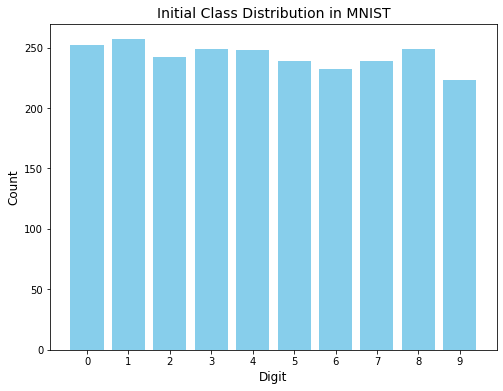

In [48]:
# Count occurrences of each digit (class) in the dataset
class_counts = {}
for input,target in DataLoader(mnist_trainset, batch_size=1, shuffle=True):
    label=target.item()
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Sort class counts by digit (0-9)
sorted_class_counts = {digit: class_counts[digit] for digit in sorted(class_counts)}

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color='skyblue')
plt.xticks(range(10), labels=[str(i) for i in range(10)])
plt.xlabel('Digit', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Initial Class Distribution in MNIST', fontsize=14)
plt.show()

In [ ]:
mnist_test_accuracy = train_with_early_stopping(mnist_trainloader, mnist_valloader, mnist_testloader, mnist_model, mnist_optimizer, criterion)

KeyboardInterrupt: 

In [49]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

In [46]:
save_model(mnist_model, 'mnist_AN_final.pth')

In [50]:
load_model(mnist_model, 'mnist_AN_final.pth')

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

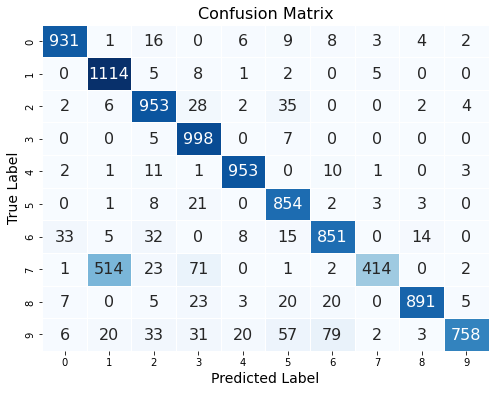

In [51]:
pred_labels_np = []
true_labels_np = []
with torch.no_grad():
    for inputs, labels in mnist_testloader: # batch wise for loop. 
        outputs = mnist_model(inputs)
        _, predicted = torch.max(outputs, 1)
        pred_labels_np.extend(predicted.numpy())
        true_labels_np.extend(labels.numpy())


# Compute confusion matrix
cm = confusion_matrix(true_labels_np, pred_labels_np,labels=[0,1,2,3,4,5,6,7,8,9])
cm_df = pd.DataFrame(cm, index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])

# Define a custom formatting function to truncate or format the values
def format_value(value):
    return f'{value:.1f}'  # Example: truncate to 1 decimal place

# Plot confusion matrix as heatmap with custom formatting
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='.0f', linewidths=.5, annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

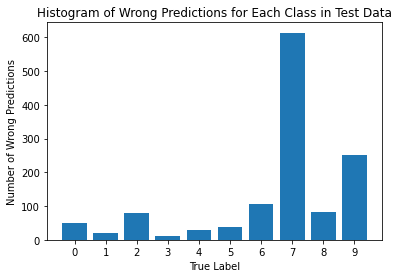

In [52]:
wrong_predictions = {i: 0 for i in range(10)}  # Initialize a dictionary to count wrong predictions for each class

with torch.no_grad():
    for images, labels in DataLoader(mnist_testset, batch_size=64, shuffle=False):
        outputs = mnist_model(images)
        _, predicted = torch.max(outputs, 1)
        # Compare predicted labels with true labels to identify incorrect predictions
        wrong_indices = (predicted != labels).nonzero().squeeze()
        if wrong_indices.numel() > 0:
            if wrong_indices.dim() == 0:  # Handle the case when there's only one wrong prediction
                wrong_indices = wrong_indices.unsqueeze(0)
            for index in wrong_indices:
                wrong_label = labels[index].item()
                wrong_predictions[wrong_label] += 1

# Step 4: Plot the histogram of wrong predictions for each class
plt.bar(range(10), [wrong_predictions[i] for i in range(10)], tick_label=range(10))
plt.xlabel('True Label')
plt.ylabel('Number of Wrong Predictions')
plt.title('Histogram of Wrong Predictions for Each Class in Test Data')
plt.show()

Finding failure sets

In [53]:
failure_loader,failure_set,correct_set= create_failure_set(mnist_testloader, mnist_model)
half_len = len(failure_set) // 2
indices = torch.randperm(len(failure_set)).tolist()
q_indices, h_indices = indices[:half_len], indices[half_len:]
# Create subsets of the list and the dataset
failure_set_query = torch.utils.data.Subset(failure_set, q_indices)
failure_hold_out = torch.utils.data.Subset(failure_set, h_indices)


The size of the failure set is  1283


Cause identification:<br>
- Linear influence

In [ ]:
r=linear_influence_function(mnist_trainset,mnist_model,criterion,failure_set_query,gamma=0.01)
sorted_pairs = sorted(r, key=sort_key)
top_10=sorted_pairs[:10]

- EWC influence- add code here

In [46]:
ewc_influences_AN, failure_causes_AN, failure_indices_AN = EWC_influence(mnist_model, mnist_trainloader, mnist_testloader, "mnist_AN", 0.01, 0.1, 10, use_existing=False)

Finding diagonal fisher
10


Creating failure set
The size of the failure set is  1283
Doing laplace approximation using SGD
65642
torch.Size([65642, 65642])


100%|██████████| 10/10 [59:25<00:00, 356.52s/it]


Computing EWC influence


Finding EWC influence: 100%|██████████| 38/38 [00:05<00:00,  6.71it/s]


Finding failure causes
[57, 1284, 316, 1312, 164, 478, 1162, 55, 92, 1895, 639, 2123, 1387, 796, 2225, 383, 642, 471, 1132, 255, 101, 48, 0, 1538, 909, 1193, 375, 1659, 1875, 1218, 563, 1460, 1637, 1489, 1096, 804, 1558, 188, 1473, 1892, 2387, 2085, 1256, 996, 142, 2156, 1494, 1382, 731, 2352, 638, 267, 71, 885, 643, 1268, 2206, 2404, 106, 674, 725, 2374, 1984, 1121, 2001, 1920]
66


In [49]:
# Save the variables to pickle files
with open('ewc_influences_AN.pkl', 'wb') as f:
    pickle.dump(ewc_influences_AN, f)

with open('failure_causes_AN.pkl', 'wb') as f:
    pickle.dump(failure_causes_AN, f)

with open('failure_indices_AN.pkl', 'wb') as f:
    pickle.dump(failure_indices_AN, f)

In [54]:
# Load ewc_influences_AN
with open('ewc_influences_AN.pkl', 'rb') as f:
    ewc_influences_AN = pickle.load(f)

# Load failure_causes_AN
with open('failure_causes_AN.pkl', 'rb') as f:
    failure_causes_AN = pickle.load(f)

# Load failure_indices_AN
with open('failure_indices_AN.pkl', 'rb') as f:
    failure_indices_AN = pickle.load(f)

tensor(5.2269)
tensor(5.0010)
tensor(4.8886)
tensor(4.8382)
tensor(4.2006)
tensor(4.0898)
tensor(3.6247)
tensor(3.1925)
tensor(2.8782)
tensor(2.8636)
tensor(2.7713)
tensor(2.7288)
tensor(2.6959)
tensor(2.5490)
tensor(2.4475)
tensor(2.4193)


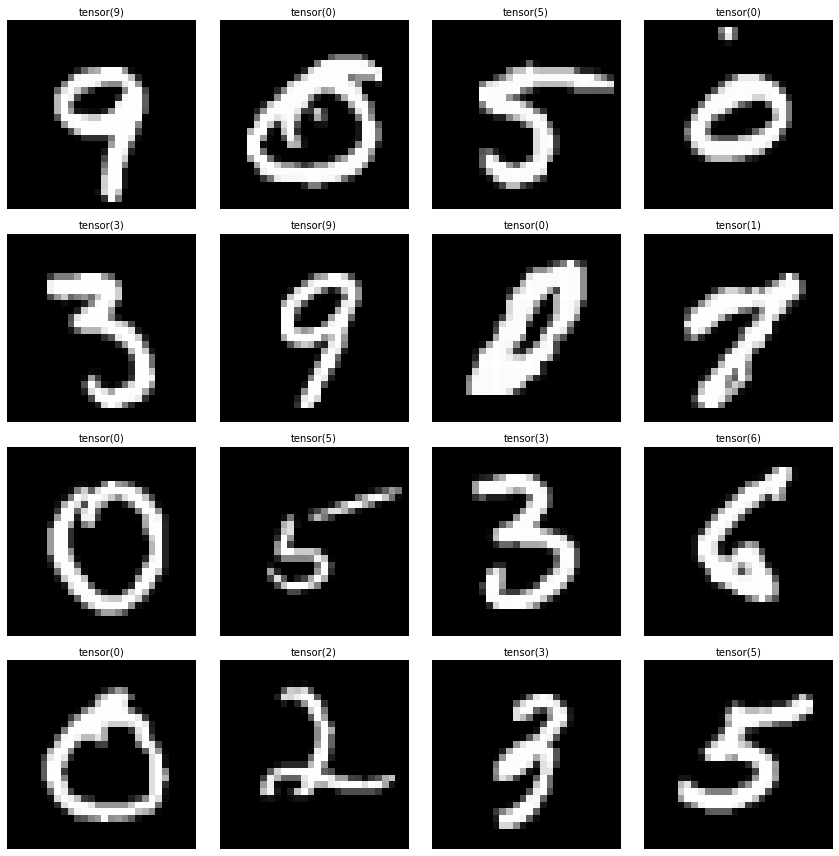

In [55]:
plot_images_with_highest_influences(mnist_trainset, ewc_influences_AN)

In [22]:
causal_set_input=[]
causal_set_target=[]
causal_size=0
for i in sorted_pairs:
    causal_size=causal_size+1
    causal_set_input.append(i[0][0])
    causal_set_target.append(i[0][1])
    if causal_size==500:
        break
causal_set=torch.utils.data.TensorDataset(torch.stack(causal_set_input),torch.tensor(causal_set_target))

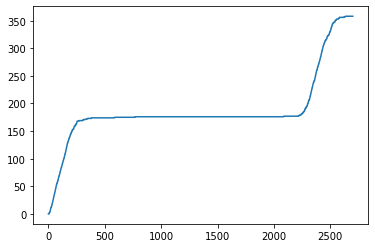

In [23]:
x=[]
cnt=0
for batch_idx,((images, labels, train_idx),r) in enumerate(sorted_pairs):
    if train_idx in idx:
        cnt+=1
    x.append(cnt)
plt.plot(x)

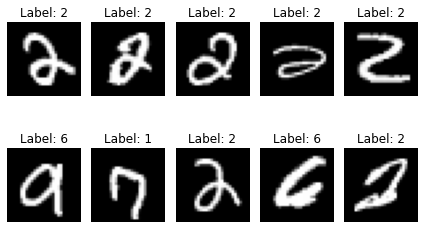

In [24]:
for batch_idx,((images, labels, train_idx),r_z) in enumerate(top_10):
    # Plot each image in the batch
    plt.subplot(2, 5, batch_idx + 1)  # Create subplot (2 rows, 5 columns)
    image = images[0].squeeze().numpy()  # Squeeze to remove batch dimension, convert to numpy array
    plt.imshow(image, cmap='gray')  # Display image in grayscale
    plt.title(f'Label: {labels[0]}')  # Display corresponding label as title
    plt.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

F is the failure set denoting the examples on which there is wrong prediction

Treatment methods
- MLE on D\C

In [159]:
# Find failure causes C
top_k = 1000 # Change to desired value if you want to select top k points
failure_causes, failure_indices = find_failure_causes(mnist_trainloader, ewc_influences_AN, top_k)
print("The size of the identified failure set C is ",len(failure_causes))
# Create a corrected DataLoader
corrected_dataloader_AN = create_corrected_dataloader(mnist_trainloader, failure_indices)
print(len(corrected_dataloader_AN))
# Fine-tune theta on corrected data D\C
theta_hat_AN= torch.cat([param.view(-1) for param in mnist_model.parameters()])
model_MLE_AN, losses = fine_tune_theta_on_corrected_data(model=mnist_model, theta= theta_hat_AN, data_loader=corrected_dataloader_AN, num_epochs=5, lr=0.01)
save_model(model_MLE_AN, 'model_MLE_AN.pth')

[57, 1284, 316, 1312, 164, 478, 1162, 55, 92, 1895, 639, 2123, 1387, 796, 2225, 383, 642, 471, 1132, 255, 101, 48, 0, 1538, 909, 1193, 375, 1659, 1875, 1218, 563, 1460, 1637, 1489, 1096, 804, 1558, 188, 1473, 1892, 2387, 2085, 1256, 996, 142, 2156, 1494, 1382, 731, 2352, 638, 267, 71, 885, 643, 1268, 2206, 2404, 106, 674, 725, 2374, 1984, 1121, 2001, 1920, 246, 1323, 482, 1455, 1158, 144, 1313, 22, 2419, 15, 1068, 1322, 2113, 1695, 1184, 754, 2017, 1955, 205, 1482, 1990, 1277, 1877, 1732, 95, 1118, 1443, 1140, 2428, 1578, 2170, 792, 1708, 1245, 872, 869, 723, 2159, 2234, 2363, 1935, 2228, 2384, 2207, 1722, 2226, 985, 1606, 270, 1975, 1231, 1880, 2224, 469, 660, 116, 39, 2038, 2403, 2158, 881, 522, 459, 2218, 1516, 1430, 1916, 1523, 2354, 1557, 53, 2105, 2022, 1580, 1918, 321, 632, 749, 1425, 1713, 912, 128, 2204, 2421, 2217, 1421, 2006, 1625, 874, 334, 1634, 695, 1615, 1944, 418, 2164, 1787, 326, 1560, 1283, 4, 903, 1074, 1874, 1404, 582, 141, 1401, 1668, 1603, 2392, 453, 2020, 1665, 1

Fine-tuning on Corrected Data:  20%|██        | 1/5 [00:04<00:19,  4.91s/it]

Epoch [1/5], Loss: 0.4975


Fine-tuning on Corrected Data:  40%|████      | 2/5 [00:09<00:14,  4.92s/it]

Epoch [2/5], Loss: 0.4840


Fine-tuning on Corrected Data:  60%|██████    | 3/5 [00:14<00:09,  4.90s/it]

Epoch [3/5], Loss: 0.4756


Fine-tuning on Corrected Data:  80%|████████  | 4/5 [00:19<00:04,  4.99s/it]

Epoch [4/5], Loss: 0.4692


Fine-tuning on Corrected Data: 100%|██████████| 5/5 [00:24<00:00,  4.95s/it]

Epoch [5/5], Loss: 0.4641


In [134]:
mnist_new_AN= MNIST_CNN()
mnist_new_optimizer = optim.Adam(mnist_new_AN.parameters(), lr=1e-3, betas=(0.9, 0.999))
mnist_test_accuracy = train_with_early_stopping(corrected_dataloader_AN, mnist_valloader, mnist_testloader, mnist_new_AN, mnist_new_optimizer, criterion)

Epoch 1: Validation Accuracy: 0.0962962962962963
Epoch 2: Validation Accuracy: 0.25555555555555554
Epoch 3: Validation Accuracy: 0.4148148148148148
Epoch 4: Validation Accuracy: 0.5407407407407407
Epoch 5: Validation Accuracy: 0.5740740740740741
Epoch 6: Validation Accuracy: 0.6111111111111112
Epoch 7: Validation Accuracy: 0.6592592592592592
Epoch 8: Validation Accuracy: 0.6703703703703704
Epoch 9: Validation Accuracy: 0.674074074074074
Epoch 10: Validation Accuracy: 0.6962962962962963
Epoch 11: Validation Accuracy: 0.7111111111111111
Epoch 12: Validation Accuracy: 0.737037037037037
Epoch 13: Validation Accuracy: 0.762962962962963
Epoch 14: Validation Accuracy: 0.7592592592592593
Epoch 15: Validation Accuracy: 0.7666666666666667
Epoch 16: Validation Accuracy: 0.7777777777777778
Epoch 17: Validation Accuracy: 0.7777777777777778
Epoch 18: Validation Accuracy: 0.7814814814814814
Epoch 19: Validation Accuracy: 0.7851851851851852
Epoch 20: Validation Accuracy: 0.7962962962962963
Epoch 21: V

Different from MLE method because here we are using the validation set as the way to stop training rather than looking only at the training set. 

In [135]:
find_accuracy(mnist_model, failure_set_query, failure_hold_out, correct_set)

Accuracy on query set is:  0.0
Accuracy on hold out is:  0.0
Accuracy on correct set is:  1.0


As expected, so we are using correct failure set 

In [160]:
find_accuracy(model_MLE_AN, failure_set_query, failure_hold_out, correct_set)

Accuracy on query set is:  0.5195007800312013
Accuracy on hold out is:  0.5155763239875389
Accuracy on correct set is:  0.8964093151313526


In [136]:
find_accuracy(mnist_new_AN, failure_set_query, failure_hold_out, correct_set)

Accuracy on query set is:  0.6162246489859594
Accuracy on hold out is:  0.5950155763239875
Accuracy on correct set is:  0.9018010783526442


- Newton update

In [27]:
acc_fail,acc_corr=newton_step(mnist_trainset,mnist_model,criterion,DataLoader(causal_set,batch_size=1),gamma=[7e-7,9e-7,1e-6,2e-6,3e-6,4e-6,5e-6])


Going to calculate FIM
Done with FIM calculations
tensor([0.0138, 0.0090, 0.0078,  ..., 0.0507, 0.0030, 0.0449])
tensor([ 72.3620, 111.4085, 128.3746,  ...,  19.7133, 328.8596,  22.2898])
7e-07
Accuracy on query set is:  0.03248259860788863
Accuracy on hold out is:  0.015081206496519721
Accuracy on correct set is:  0.9864668922184631
9e-07
Accuracy on query set is:  0.042923433874709975
Accuracy on hold out is:  0.025522041763341066
Accuracy on correct set is:  0.9821169647172547
1e-06
Accuracy on query set is:  0.04640371229698376
Accuracy on hold out is:  0.030162412993039442
Accuracy on correct set is:  0.9805461575640406
2e-06
Accuracy on query set is:  0.06728538283062645
Accuracy on hold out is:  0.04640371229698376
Accuracy on correct set is:  0.9537216046399226
3e-06
Accuracy on query set is:  0.07424593967517401
Accuracy on hold out is:  0.05336426914153132
Accuracy on correct set is:  0.9079265345577574
4e-06
Accuracy on query set is:  0.07076566125290024
Accuracy on hold out

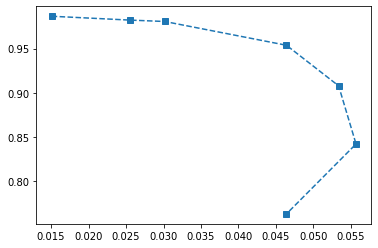

In [28]:
# plt.scatter(x=[0.31,0.33,0.23,0.12],y=[0.945,0.876,0.782,0.670])
plt.plot(acc_fail, acc_corr, linestyle='dashed', marker='s')

-EWC deletion

In [63]:
# Find failure causes C
top_k = 1000  # Change to desired value if you want to select top k points
failure_causes_AN, failure_indices_AN = find_failure_causes(mnist_trainloader, ewc_influences_AN, top_k)
print("The size of the identified failure set C is ",len(failure_causes_AN))
# Create a corrected DataLoader

[57, 1284, 316, 1312, 164, 478, 1162, 55, 92, 1895, 639, 2123, 1387, 796, 2225, 383, 642, 471, 1132, 255, 101, 48, 0, 1538, 909, 1193, 375, 1659, 1875, 1218, 563, 1460, 1637, 1489, 1096, 804, 1558, 188, 1473, 1892, 2387, 2085, 1256, 996, 142, 2156, 1494, 1382, 731, 2352, 638, 267, 71, 885, 643, 1268, 2206, 2404, 106, 674, 725, 2374, 1984, 1121, 2001, 1920, 246, 1323, 482, 1455, 1158, 144, 1313, 22, 2419, 15, 1068, 1322, 2113, 1695, 1184, 754, 2017, 1955, 205, 1482, 1990, 1277, 1877, 1732, 95, 1118, 1443, 1140, 2428, 1578, 2170, 792, 1708, 1245, 872, 869, 723, 2159, 2234, 2363, 1935, 2228, 2384, 2207, 1722, 2226, 985, 1606, 270, 1975, 1231, 1880, 2224, 469, 660, 116, 39, 2038, 2403, 2158, 881, 522, 459, 2218, 1516, 1430, 1916, 1523, 2354, 1557, 53, 2105, 2022, 1580, 1918, 321, 632, 749, 1425, 1713, 912, 128, 2204, 2421, 2217, 1421, 2006, 1625, 874, 334, 1634, 695, 1615, 1944, 418, 2164, 1787, 326, 1560, 1283, 4, 903, 1074, 1874, 1404, 582, 141, 1401, 1668, 1603, 2392, 453, 2020, 1665, 1

In [ ]:
print("Number of failure causes = ",len(failure_causes_AN))
failure_causes_dataloader = failure_causes_to_dataloader(failure_causes_AN, batch_size=32, shuffle=True)
print(len(failure_causes_dataloader))
# Call the function to update theta_hat_C using SGD for data deletion
theta_hat= torch.cat([param.view(-1) for param in mnist_model.parameters()])
lr = 0.01
lambda_val = 0.0
num_epochs = 2
N= len(mnist_trainloader.sampler)
params = {n: p for n, p in mnist_model.named_parameters() if p.requires_grad}
# Mnist model has only ten named parameters, using torch.cat with .view(-1) on the params will give ~65k params. 
print(len(params))
fisher_AN= get_fisher_diag(mnist_model, mnist_trainloader, params)
theta_hat_EWC_deletion = EWC_data_deletion(theta_hat, fisher_AN, failure_causes_dataloader, mnist_model, lr, lambda_val, num_epochs, N)
# Create a new model with parameters theta_F
model_EWC_deletion_AN = create_model_with_theta(theta_hat_EWC_deletion)
save_model(model_EWC_deletion_AN, 'model_EWC_deletion_AN.pth')

In [62]:
find_accuracy(model_EWC_deletion_AN, failure_set_query, failure_hold_out, correct_set)

Accuracy on query set is:  0.0
Accuracy on hold out is:  0.0
Accuracy on correct set is:  1.0


### Adding salt pepper noise

In [88]:
def add_salt_pepper_noise(image, salt_prob=0.1, pepper_prob=0.1):
    img_copied = image.clone()
    img_tensor = img_copied.squeeze()  # Remove batch dimension
    width, height = img_tensor.size()

    # Add salt noise
    num_salt = int(width * height * salt_prob)
    salt_coords = [random.randint(0, width - 1) for _ in range(num_salt)], \
                  [random.randint(0, height - 1) for _ in range(num_salt)]
    img_tensor[salt_coords] = 1.0

    # Add pepper noise
    num_pepper = int(width * height * pepper_prob)
    pepper_coords = [random.randint(0, width - 1) for _ in range(num_pepper)], \
                    [random.randint(0, height - 1) for _ in range(num_pepper)]
    img_tensor[pepper_coords] = 0.0

    return img_tensor.unsqueeze(0)  # Add batch dimension back

### 2) Experiments with adding input noise 

In [103]:
# Define the root directory for data
data_root = './data'

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])

# Check if MNIST dataset is already downloaded, if not, download it
if not os.path.exists(os.path.join(data_root, 'MNIST')):
    mnist_trainset = torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
    mnist_testset = torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform=transform)
else:
    mnist_trainset = torchvision.datasets.MNIST(root=data_root, train=True, download=False, transform=transform)
    mnist_testset = torchvision.datasets.MNIST(root=data_root, train=False, download=False, transform=transform)

def stratified_sample(dataset, n_samples_per_class):
    labels = dataset.targets.numpy()
    classes = np.unique(labels)
    
    selected_indices = []
    for cls in classes:
        cls_indices = np.where(labels == cls)[0]
        selected_cls_indices = np.random.choice(cls_indices, size=n_samples_per_class, replace=False)
        selected_indices.extend(selected_cls_indices)
    
    return selected_indices

n_samples_per_class = 300
selected_indices = stratified_sample(mnist_trainset, n_samples_per_class)
mnist_trainset = torch.utils.data.Subset(mnist_trainset, selected_indices)
noised_num=0

def add_salt_pepper_labels_on_digits(subset, noised_num, digit1, salt_probability=0.3):
    salt_idx=[]
    subset_data = torch.stack([subset[i][0] for i in range(len(subset))])
    subset_labels = torch.tensor([subset[i][1] for i in range(len(subset))])
    
    for idx in range(len(subset)):
        if int(subset_labels[idx]) is digit1:
            # Flip label from digit1 to digit2 with the specified probability
            if random.random() < salt_probability:
                # print("ADdinhg noise!")
                noised_num+=1
                salt_idx.append(idx)
                subset_data[idx] = add_salt_pepper_noise(subset_data[idx])
        # print(subset_labels[idx])
    
    # Create a new subset dataset with the modified labels
    salted_subset = torch.utils.data.TensorDataset(subset_data, subset_labels)
    # print(noised_num)
    return salted_subset,salt_idx, noised_num
salted_mnist_trainset,idx1, noised_num = add_salt_pepper_labels_on_digits(mnist_trainset, noised_num, digit1=7)
salted_mnist_trainset,idx2, noised_num  = add_salt_pepper_labels_on_digits(salted_mnist_trainset, noised_num, digit1=1)
salted_mnist_trainset,idx3, noised_num  = add_salt_pepper_labels_on_digits(salted_mnist_trainset, noised_num, digit1=6)
salted_mnist_trainset,idx4, noised_num  = add_salt_pepper_labels_on_digits(salted_mnist_trainset, noised_num, digit1=9)
idx = idx1+ idx2+idx3+idx4
noised_indexes= idx
print("Total noised images are ", noised_num)
# mnist_trainset = salted_mnist_trainset
# Initialize models and optimizer
torch.manual_seed(seed)
mnist_model_IN = MNIST_CNN()
mnist_optimizer = optim.Adam(mnist_model_IN.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss() # multiclassification
train_size_mnist = int(0.9 * len(salted_mnist_trainset))
print(len(salted_mnist_trainset))
indices = torch.randperm(len(salted_mnist_trainset)).tolist()
train_indices, val_indices = indices[:train_size_mnist], indices[train_size_mnist:]
og_mnist_trainset = salted_mnist_trainset
# Create subsets of the list and the dataset
salted_mnist_valset = torch.utils.data.Subset(salted_mnist_trainset, val_indices)
salted_mnist_trainset = torch.utils.data.Subset(salted_mnist_trainset, train_indices)

# Define data loaders for training, validation, and testing
salted_mnist_trainloader = DataLoader(salted_mnist_trainset, batch_size=64, shuffle=True)
salted_mnist_valloader = DataLoader(salted_mnist_valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

Total noised images are  342
3000


In [104]:
mnist_test_accuracy = train_with_early_stopping(salted_mnist_trainloader, salted_mnist_valloader, mnist_testloader, mnist_model_IN, mnist_optimizer, criterion)

Epoch 1: Validation Accuracy: 0.25333333333333335
Epoch 2: Validation Accuracy: 0.45
Epoch 3: Validation Accuracy: 0.6533333333333333
Epoch 4: Validation Accuracy: 0.7333333333333333
Epoch 5: Validation Accuracy: 0.8133333333333334
Epoch 6: Validation Accuracy: 0.82
Epoch 7: Validation Accuracy: 0.89
Epoch 8: Validation Accuracy: 0.8766666666666667
Epoch 9: Validation Accuracy: 0.9133333333333333
Epoch 10: Validation Accuracy: 0.8666666666666667
Epoch 11: Validation Accuracy: 0.93
Epoch 12: Validation Accuracy: 0.9533333333333334
Epoch 13: Validation Accuracy: 0.94
Epoch 14: Validation Accuracy: 0.94
Epoch 15: Validation Accuracy: 0.9333333333333333
Epoch 16: Validation Accuracy: 0.94
Epoch 17: Validation Accuracy: 0.95
No improvement for 5 epochs. Early stopping...
Test Accuracy: 0.9404


In [105]:
save_model(mnist_model, 'mnist_IN_final.pth')

In [ ]:
load_model(mnist_model, 'mnist_IN_final.pth')

Finding failure sets

In [122]:
failure_loader_IN,failure_set_IN,correct_set_IN= create_failure_set(mnist_testloader, mnist_model_IN)
half_len_IN = len(failure_set_IN) // 2
indices_IN = torch.randperm(len(failure_set_IN)).tolist()
q_indices_IN, h_indices_IN = indices_IN[:half_len], indices_IN[half_len:]
# Create subsets of the list and the dataset
failure_set_query_IN = torch.utils.data.Subset(failure_set_IN, q_indices_IN)
failure_hold_out_IN = torch.utils.data.Subset(failure_set_IN, h_indices_IN)

The size of the failure set is  936


- Linear influence

In [ ]:
r=linear_influence_function(salted_mnist_trainset,mnist_model_IN,criterion,failure_set_query_IN,gamma=0.01)
sorted_pairs = sorted(r, key=sort_key)
top_10=sorted_pairs[:10]
# print(top_10)
x=[]
cnt=0
for batch_idx,((images, labels, train_idx),r) in enumerate(sorted_pairs):
    if train_idx in idx:
        cnt+=1
    x.append(cnt)
plt.plot(x)

- EWC influence

In [106]:
ewc_influences_IN, failure_causes_IN, failure_indices_IN = EWC_influence(mnist_model_IN, salted_mnist_trainloader, mnist_testloader, "mnist_IN", 0.01, 0.1, 1, use_existing=False, calculate_failure= False)

Finding diagonal fisher
10


Creating failure set
The size of the failure set is  596
Doing laplace approximation using SGD
65642
torch.Size([65642, 65642])


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.332284688949585


Loss: 2.3700013160705566


Loss: 2.332496404647827


Loss: 2.138759136199951


Loss: 2.2211854457855225


Loss: 2.3755617141723633


Loss: 2.4835596084594727


Loss: 2.3624868392944336


Loss: 2.375126600265503


Loss: 2.354752540588379


100%|██████████| 1/1 [03:06<00:00, 186.37s/it]


Computing EWC influence


Finding EWC influence: 100%|██████████| 43/43 [00:04<00:00,  8.69it/s]


tensor(3.8550)
tensor(3.8451)
tensor(3.7167)
tensor(3.4731)
tensor(3.4077)
tensor(3.0013)
tensor(2.9104)
tensor(2.8996)
tensor(2.8309)
tensor(2.5310)
tensor(2.5281)
tensor(1.9319)
tensor(1.9307)
tensor(1.8759)
tensor(1.8216)
tensor(1.7736)


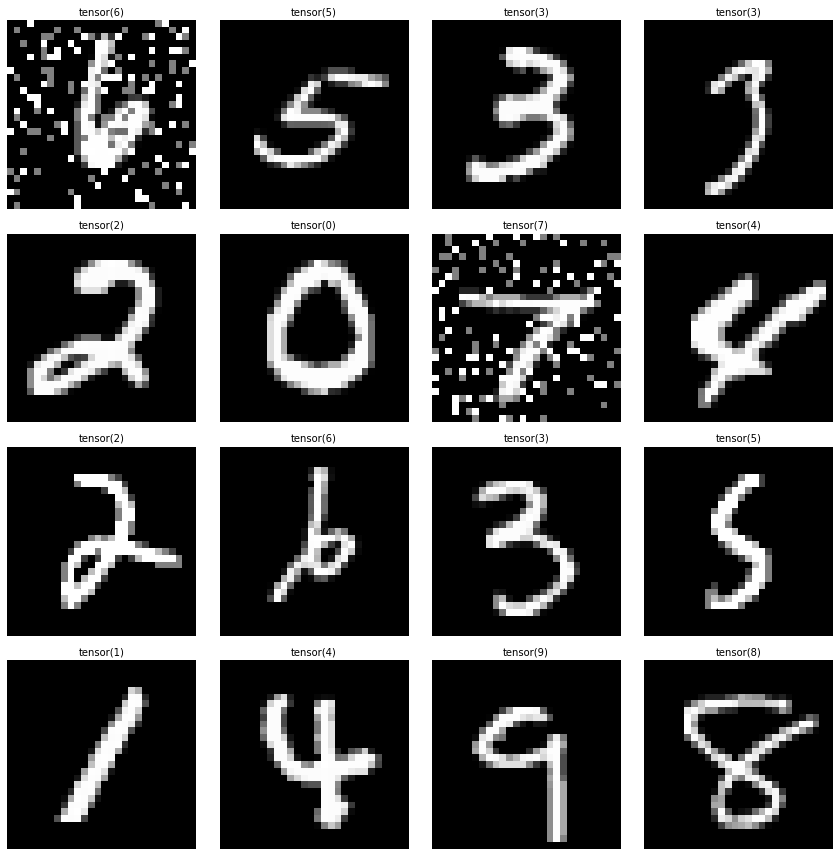

In [107]:
plot_images_with_highest_influences(salted_mnist_trainset, ewc_influences_IN)

Treatment methods
- MLE on D\C

In [162]:
# Find failure causes C
top_k = 100  # Change to desired value if you want to select top k points
failure_causes_IN, failure_indices_IN = find_failure_causes(salted_mnist_trainloader, ewc_influences_IN, top_k)
print("The size of the identified failure set C is ",len(failure_causes_IN))
# Create a corrected DataLoader
corrected_dataloader = create_corrected_dataloader(salted_mnist_trainloader, failure_indices_IN)
print(len(corrected_dataloader))
# Fine-tune theta on corrected data D\C
theta_hat_IN= torch.cat([param.view(-1) for param in mnist_model_IN.parameters()])
# theta_MLE_IN, losses = fine_tune_theta_on_corrected_data(model=mnist_model_IN, theta= theta_hat_IN, data_loader=corrected_dataloader, num_epochs=10, lr=0.01)
# model_MLE_IN= create_model_with_theta(theta_MLE_IN)
model_MLE_IN, losses = fine_tune_theta_on_corrected_data(model=mnist_model_IN, theta= theta_hat_IN, data_loader=corrected_dataloader, num_epochs=30, lr=0.01)
save_model(model_MLE_IN, 'model_MLE_IN.pth')

[604, 909, 954, 129, 1447, 1469, 721, 215, 1773, 2681, 665, 1177, 128, 1571, 1526, 616, 1346, 2609, 2341, 2516, 1991, 1427, 2109, 2628, 542, 979, 2047, 1132, 1550, 1337, 957, 2057, 1432, 911, 2309, 1385, 123, 2145, 127, 703, 2528, 1543, 2383, 839, 2620, 21, 1487, 2542, 1753, 1905, 2256, 308, 532, 611, 345, 2415, 650, 1193, 2501, 159, 488, 1700, 2555, 904, 1908, 438, 977, 2032, 29, 489, 2408, 1867, 1898, 2318, 2117, 1011, 880, 2562, 1505, 906, 1012, 2050, 2454, 2156, 2371, 2657, 1895, 1551, 800, 1349, 1925, 2034, 1031, 252, 1501, 1370, 1221, 1943, 2696, 713]
The size of the identified failure set C is  100
Number of images in corrected dataset are:  2600
41


Fine-tuning on Corrected Data:   3%|▎         | 1/30 [00:09<04:24,  9.14s/it]

Epoch [1/30], Loss: 0.1940


Fine-tuning on Corrected Data:   7%|▋         | 2/30 [00:18<04:11,  8.99s/it]

Epoch [2/30], Loss: 0.1826


Fine-tuning on Corrected Data:  10%|█         | 3/30 [00:26<04:01,  8.95s/it]

Epoch [3/30], Loss: 0.1791


Fine-tuning on Corrected Data:  13%|█▎        | 4/30 [00:35<03:53,  8.96s/it]

Epoch [4/30], Loss: 0.1761


Fine-tuning on Corrected Data:  17%|█▋        | 5/30 [00:44<03:43,  8.94s/it]

Epoch [5/30], Loss: 0.1734


Fine-tuning on Corrected Data:  20%|██        | 6/30 [00:53<03:34,  8.92s/it]

Epoch [6/30], Loss: 0.1708


Fine-tuning on Corrected Data:  23%|██▎       | 7/30 [01:02<03:25,  8.93s/it]

Epoch [7/30], Loss: 0.1684


Fine-tuning on Corrected Data:  27%|██▋       | 8/30 [01:11<03:16,  8.92s/it]

Epoch [8/30], Loss: 0.1661


Fine-tuning on Corrected Data:  30%|███       | 9/30 [01:20<03:07,  8.91s/it]

Epoch [9/30], Loss: 0.1640


Fine-tuning on Corrected Data:  33%|███▎      | 10/30 [01:29<02:58,  8.92s/it]

Epoch [10/30], Loss: 0.1619


Fine-tuning on Corrected Data:  37%|███▋      | 11/30 [01:38<02:49,  8.92s/it]

Epoch [11/30], Loss: 0.1599


Fine-tuning on Corrected Data:  40%|████      | 12/30 [01:47<02:40,  8.91s/it]

Epoch [12/30], Loss: 0.1580


Fine-tuning on Corrected Data:  43%|████▎     | 13/30 [01:56<02:31,  8.90s/it]

Epoch [13/30], Loss: 0.1562


Fine-tuning on Corrected Data:  47%|████▋     | 14/30 [02:04<02:22,  8.90s/it]

Epoch [14/30], Loss: 0.1544


Fine-tuning on Corrected Data:  50%|█████     | 15/30 [02:13<02:13,  8.90s/it]

Epoch [15/30], Loss: 0.1527


Fine-tuning on Corrected Data:  53%|█████▎    | 16/30 [02:22<02:04,  8.90s/it]

Epoch [16/30], Loss: 0.1511


Fine-tuning on Corrected Data:  57%|█████▋    | 17/30 [02:31<01:55,  8.90s/it]

Epoch [17/30], Loss: 0.1495


Fine-tuning on Corrected Data:  60%|██████    | 18/30 [02:40<01:47,  8.92s/it]

Epoch [18/30], Loss: 0.1480


Fine-tuning on Corrected Data:  63%|██████▎   | 19/30 [02:49<01:38,  8.92s/it]

Epoch [19/30], Loss: 0.1465


Fine-tuning on Corrected Data:  67%|██████▋   | 20/30 [02:58<01:29,  8.92s/it]

Epoch [20/30], Loss: 0.1451


Fine-tuning on Corrected Data:  70%|███████   | 21/30 [03:07<01:20,  8.91s/it]

Epoch [21/30], Loss: 0.1437


Fine-tuning on Corrected Data:  73%|███████▎  | 22/30 [03:16<01:11,  8.91s/it]

Epoch [22/30], Loss: 0.1423


Fine-tuning on Corrected Data:  77%|███████▋  | 23/30 [03:25<01:02,  8.92s/it]

Epoch [23/30], Loss: 0.1410


Fine-tuning on Corrected Data:  80%|████████  | 24/30 [03:34<00:53,  8.94s/it]

Epoch [24/30], Loss: 0.1397


Fine-tuning on Corrected Data:  83%|████████▎ | 25/30 [03:43<00:44,  9.00s/it]

Epoch [25/30], Loss: 0.1384


Fine-tuning on Corrected Data:  87%|████████▋ | 26/30 [03:52<00:35,  8.97s/it]

Epoch [26/30], Loss: 0.1372


Fine-tuning on Corrected Data:  90%|█████████ | 27/30 [04:01<00:26,  8.96s/it]

Epoch [27/30], Loss: 0.1359


Fine-tuning on Corrected Data:  93%|█████████▎| 28/30 [04:10<00:17,  8.94s/it]

Epoch [28/30], Loss: 0.1347


Fine-tuning on Corrected Data:  97%|█████████▋| 29/30 [04:18<00:08,  8.93s/it]

Epoch [29/30], Loss: 0.1335


Fine-tuning on Corrected Data: 100%|██████████| 30/30 [04:27<00:00,  8.93s/it]

Epoch [30/30], Loss: 0.1324


In [118]:
mnist_new= MNIST_CNN()
mnist_new_optimizer = optim.Adam(mnist_new.parameters(), lr=1e-3, betas=(0.9, 0.999))
mnist_test_accuracy = train_with_early_stopping(corrected_dataloader, salted_mnist_valloader, mnist_testloader, mnist_new, mnist_new_optimizer, criterion)

Epoch 1: Validation Accuracy: 0.3
Epoch 2: Validation Accuracy: 0.42333333333333334
Epoch 3: Validation Accuracy: 0.45666666666666667
Epoch 4: Validation Accuracy: 0.6633333333333333
Epoch 5: Validation Accuracy: 0.75
Epoch 6: Validation Accuracy: 0.86
Epoch 7: Validation Accuracy: 0.8933333333333333
Epoch 8: Validation Accuracy: 0.8966666666666666
Epoch 9: Validation Accuracy: 0.9066666666666666
Epoch 10: Validation Accuracy: 0.9166666666666666
Epoch 11: Validation Accuracy: 0.92
Epoch 12: Validation Accuracy: 0.92
Epoch 13: Validation Accuracy: 0.92
Epoch 14: Validation Accuracy: 0.9266666666666666
Epoch 15: Validation Accuracy: 0.94
Epoch 16: Validation Accuracy: 0.9366666666666666
Epoch 17: Validation Accuracy: 0.9366666666666666
Epoch 18: Validation Accuracy: 0.9366666666666666
Epoch 19: Validation Accuracy: 0.9366666666666666
Epoch 20: Validation Accuracy: 0.9366666666666666
No improvement for 5 epochs. Early stopping...
Test Accuracy: 0.9464


In [125]:
find_accuracy(mnist_model_IN, failure_set_query_IN, failure_hold_out_IN, correct_set_IN)

Accuracy on query set is:  0.0
Accuracy on hold out is:  0.0
Accuracy on correct set is:  1.0


The above shows we are using the correct failure sets. 

In [163]:
find_accuracy(model_MLE_IN, failure_set_query_IN, failure_hold_out_IN, correct_set_IN)

Accuracy on query set is:  0.5756630265210608
Accuracy on hold out is:  0.6508474576271186
Accuracy on correct set is:  0.9896293027360988


In [126]:
find_accuracy(mnist_new, failure_set_query_IN, failure_hold_out_IN, correct_set_IN)

Accuracy on query set is:  0.5756630265210608
Accuracy on hold out is:  0.5864406779661017
Accuracy on correct set is:  0.9843336275375111


- Newton update

In [ ]:
acc_fail,acc_corr=newton_step(mnist_trainset,mnist_model,criterion,DataLoader(causal_set,batch_size=1),gamma=[7e-7,9e-7,1e-6,2e-6,3e-6,4e-6,5e-6])


Going to calculate FIM
Done with FIM calculations
tensor([0.0138, 0.0090, 0.0078,  ..., 0.0507, 0.0030, 0.0449])
tensor([ 72.3620, 111.4085, 128.3746,  ...,  19.7133, 328.8596,  22.2898])
7e-07
Accuracy on query set is:  0.03248259860788863
Accuracy on hold out is:  0.015081206496519721
Accuracy on correct set is:  0.9864668922184631
9e-07
Accuracy on query set is:  0.042923433874709975
Accuracy on hold out is:  0.025522041763341066
Accuracy on correct set is:  0.9821169647172547
1e-06
Accuracy on query set is:  0.04640371229698376
Accuracy on hold out is:  0.030162412993039442
Accuracy on correct set is:  0.9805461575640406
2e-06
Accuracy on query set is:  0.06728538283062645
Accuracy on hold out is:  0.04640371229698376
Accuracy on correct set is:  0.9537216046399226
3e-06
Accuracy on query set is:  0.07424593967517401
Accuracy on hold out is:  0.05336426914153132
Accuracy on correct set is:  0.9079265345577574
4e-06
Accuracy on query set is:  0.07076566125290024
Accuracy on hold out

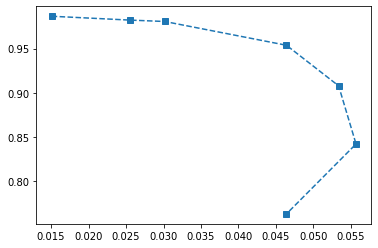

In [ ]:
# plt.scatter(x=[0.31,0.33,0.23,0.12],y=[0.945,0.876,0.782,0.670])
plt.plot(acc_fail, acc_corr, linestyle='dashed', marker='s')

-EWC deletion

In [164]:
failure_causes_dataloader = failure_causes_to_dataloader(failure_causes_IN, batch_size=32, shuffle=True)
print(len(failure_causes_dataloader))
# Call the function to update theta_hat_C using SGD for data deletion
theta_hat= torch.cat([param.view(-1) for param in mnist_model.parameters()])
lr = 0.01
lambda_val = 0.1
num_epochs = 10
N= len(mnist_trainloader.sampler)
params = {n: p for n, p in mnist_model.named_parameters() if p.requires_grad}
# Mnist model has only ten named parameters, using torch.cat with .view(-1) on the params will give ~65k params. 
print(len(params))
fisher_IN= get_fisher_diag(mnist_model, mnist_trainloader, params)
theta_hat_EWC_deletion = EWC_data_deletion(theta_hat, fisher_IN, failure_causes_dataloader, mnist_model, lr, lambda_val, num_epochs, N)
# Create a new model with parameters theta_F
model_EWC_deletion_IN = create_model_with_theta(theta_hat_EWC_deletion)
save_model(model_EWC_deletion_IN, 'model_EWC_deletion_IN.pth')

4
10


 30%|███       | 3/10 [03:47<08:58, 76.89s/it]                        

In [ ]:
find_accuracy(model_EWC_deletion_IN, failure_set_query, failure_hold_out, correct_set)

We have right now learnt a point estimate rather than a posterior on theta, and have written code for identifyinhg failure set F. The next step is first to find the approximate posterior q(θ) ~ p(θ|D). Then we will appply a continual learning method to obtain the modified posterior q+F(θ) ~ p(θ|D, F) after fitting failure set F. In order to find a subset C of cardinality K that leads to the maximal ˆr(C), it suffices to compute ˆr(z) for every training example z ∈ D and find the top K examples with largest ˆr(z) values. We show two methods of approximating ˆr(z): Linear influence functions and EWC.

The fisher matrix is used extensively in the upcoming methods. Fisher Information Matrix (FIM) is covariance matrix of score function <br>For a single data point, $F(x) = \mathbb{E}_{p_{\theta}(y|x)}[\nabla_{\theta} \log p_{\theta}(y|x) (\nabla_{\theta} \log p_{\theta}(y|x))^{\top}]$. For an entire dataset, we have $F = \sum_{n} F_{x_n} = \sum_{n} \mathbb{E}_{p_{\theta}(y|x_n)}[\nabla_{\theta} \log p_{\theta}(y|x_n) (\nabla_{\theta} \log p_{\theta}(y|x_n))^{\top}]
$ Each entry 𝐹 tells us how “sensitive” the model is w.r.t. the pair $(\theta_i , \theta_j )$. <br> In practise, we use the emperical fisher matrix $\tilde{F} = \sum_{n} [\nabla_{\theta} \log p_{\theta}(y_n|x_n) (\nabla_{\theta} \log p_{\theta}(y_n|x_n))^{\top}]$. The difference, of course, is that rather than sampling y
 from the model itself, here, we use the observed labels $y_n$
 from the dataset



###  3) Experiments with adding FGSM noise(to be added)

## Extra code from before that might help complete above code:

- SGD influence

In [ ]:
# Example usage
theta_hat = mnist_model.parameters()  # Assuming theta_hat is the parameter vector of the mnist_model
failure_loader1 = create_failure_set(mnist_testloader, mnist_model)[0]  # Failure set DataLoader
lr = 0.01  # Learning rate
num_steps = 100  # Number of optimization stepslinear_influence_gd_result = linear_influence_gd(mnist_model, theta_hat, failure_loader1, lr, num_steps)

print("Linear Influence (GD):", linear_influence_gd_result)
theta_hat=mnist_model.parameters()
v_reshaped=reshape_v_to_theta_hat(linear_influence_gd_result, theta_hat)

Finding EWC influences

In [ ]:
params = {n: p for n, p in mnist_model.named_parameters() if p.requires_grad}
# Mnist model has only ten named parameters, using torch.cat with .view(-1) on the params will give ~65k params. 
print(len(params))
fisher= get_fisher_diag(mnist_model, mnist_trainloader, params)

In [ ]:
mnist_laplace_approx= create_model_with_theta(theta_F)
save_model(mnist_laplace_approx, 'mnist_laplace_approx.pth')

In [ ]:
# print(mnist_newmodel.parameters())mnist_laplace_approx= MNIST_CNN()
load_model(mnist_laplace_approx, 'mnist_laplace_approx.pth')

In [ ]:
lr = 0.01
lambda_val = 0.1
num_epochs = 10
N= len(mnist_trainloader.sampler)
failure_loader = create_failure_set(mnist_testloader, mnist_model)[0]
print(type(failure_loader))

In [ ]:
theta_hat= torch.cat([param.view(-1) for param in mnist_model.parameters()])
theta_F = find_theta_F(theta_hat, fisher, failure_loader, mnist_model, lr, lambda_val, num_epochs, N)

In [ ]:
ewc_influences = compute_ewc_influences(mnist_trainloader, mnist_model, mnist_laplace_approx)

Treatment method 1

In [ ]:
# Find failure causes C
top_k = None  # Change to desired value if you want to select top k points
failure_causes, failure_indices = find_failure_causes(mnist_trainloader, ewc_influences, top_k)
print(len(failure_causes))
# Create a corrected DataLoader
corrected_dataloader = create_corrected_dataloader(mnist_trainloader, failure_indices)
print(len(corrected_dataloader))
# Fine-tune theta on corrected data D\C
# theta= torch.cat([param.view(-1) for param in mnist_model.parameters()])
theta_MLE, losses = fine_tune_theta_on_corrected_data(model=mnist_model, theta= theta_hat, data_loader=corrected_dataloader, num_epochs=10, lr=0.01)

The repaired model is updated_model, which we obtained by maximimising log likelihood of the Dataset with failure causes C removed. It is like basic MLE solution. 

EWC deletion

In [ ]:
failure_causes_dataloader = failure_causes_to_dataloader(failure_causes, batch_size=32, shuffle=True)
print(len(failure_causes_dataloader))
# Call the function to update theta_hat_C using SGD for data deletion
theta_hat= torch.cat([param.view(-1) for param in mnist_model.parameters()])
lr = 0.01
lambda_val = 0.1
num_epochs = 10
N= len(mnist_trainloader.sampler)

theta_hat_EWC_deletion = EWC_data_deletion(theta_hat, fisher_IN, failure_causes_dataloader, mnist_model, lr, lambda_val, num_epochs, N)
# Create a new model with parameters theta_F
model_EWC_deletion = create_model_with_theta(theta_hat_EWC_deletion)
save_model(model_EWC_deletion, 'model_EWC_deletion.pth')

## Experiments:
1) Annotation noise:
- Create noised dataset with label noise, with ground truth to indicate which points have been labeled incorrectly
- Train new model on noisy dataset 
- Apply cause identification algorithms to find influences of training points 
- Plot the top 16 images in a 4*4 grid that have the highest influence values according to EWC influence, along with their label in the noised dataset. 

In [ ]:
class NoisedMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, cm):
        self.original_dataset = original_dataset
        self.cm = cm
        self.noised_labels, self.noisy_indices, self.misclassfcn_dict = self._flip_labels()

    def _flip_labels(self):
        noisy_labels = []
        noisy_indices = []
        misclassfcn_dict = {i: 0 for i in range(10)}
        
        for idx, (input, label) in enumerate(self.original_dataset):
            # for label in labels:
                # Randomly flip the label according to the confusion matrix
                noisy_label = np.random.choice(np.arange(len(self.cm)), p=self.cm[label])
                noisy_labels.append(noisy_label)
                if noisy_label != label:
                    misclassfcn_dict[int(label)] += 1
                    noisy_indices.append(idx)
                    
        return noisy_labels, noisy_indices, misclassfcn_dict

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        noised_label = self.noised_labels[index]
        return image,  noised_label # stopped returning label 

    def __len__(self):
        return len(self.original_dataset)

Generating the train, test datasets for annotation noise case:

In [ ]:
# Create a new dataset with noisy labels
noised_mnist_dataset = NoisedMNISTDataset(mnist_trainset, mnist_cm)

# Randomly select 3000 points for training
train_indices = torch.randperm(len(noised_mnist_dataset))[:3000]
trainset = torch.utils.data.Subset(noised_mnist_dataset, train_indices)

# Define a DataLoader for the training set
mnist_trainloader_AN = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
mnist_AN = MNIST_CNN() # mnist model with Annotation noise 
mnist_optimizer_AN = optim.Adam(mnist_AN.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion_AN = nn.CrossEntropyLoss() # multiclassification
# Store which images were noised as ground truth
noised_ground_truth = torch.zeros(len(mnist_trainset), dtype=torch.bool)
noised_ground_truth[noised_mnist_dataset.noisy_indices] = True

# Define the size of the validation set (10% of the training set)
validation_size_mnist = int(0.1 * len(trainset))

# Split the training set into training and validation sets
trainset, valset = torch.utils.data.random_split(trainset, [len(trainset) - validation_size_mnist, validation_size_mnist])

# Define data loaders for training, validation, and testing
mnist_trainloader_AN = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
mnist_valloader_AN = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
mnist_testloader_AN = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False)


In [ ]:
mnist_test_accuracy_AN = train_with_early_stopping(mnist_trainloader_AN, mnist_valloader_AN, mnist_testloader_AN, mnist_AN, mnist_optimizer_AN, criterion_AN)


In [ ]:
save_model(mnist_AN, 'mnist_AN_3000.pth')

In [ ]:
ewc_influences_AN, failure_causes_AN, failure_indices_AN = EWC_influence(mnist_AN, mnist_trainloader_AN, mnist_testloader_AN, "mnist_AN", 0.01, 0.1, 10, use_existing=False)

In [ ]:
print(len(ewc_influences_AN))

In [ ]:
def plot_incorrect_labels_fixed(trainloader, influences, incorrect_labels_indices, algo_names, num_runs=1):
    """
    Plot the relationship between the fraction of incorrect labels fixed and the fraction of data points inspected for multiple algorithms.

    Args:
        trainloader (DataLoader): DataLoader for the training dataset.
        influences (list of lists): List of lists containing influences of different algorithms.
        incorrect_labels_indices (list or set): List or set containing indices of data points with incorrect labels.
        algo_names (list): List containing names of different algorithms for the legend.
        num_runs (int, optional): Number of runs for computing mean and standard deviation. Defaults to 5.
    """
    fractions_inspected = np.arange(0.2, 1.1, 0.2)
    results = {name: [] for name in algo_names}

    for run in range(num_runs):
        for algo_idx, algo_influences in enumerate(influences):
            identified_causes = []
            fixed_incorrect_labels = []

            sorted_indices = np.argsort(algo_influences)

            for fraction in fractions_inspected:
                num_points_to_inspect = int(fraction * len(trainloader))
                top_points = sorted_indices[:num_points_to_inspect]
                num_matched = sum(1 for idx in top_points if idx in incorrect_labels_indices)

                # Create a subset of corrected data by removing top_points
                corrected_data_subset = [(inputs, labels) for idx, (inputs, labels) in enumerate(trainloader) if idx not in top_points]

                # Fine-tune theta on corrected data subset
                theta= torch.cat([param.view(-1) for param in model.parameters()])
                theta_MLE, _ = fine_tune_theta_on_corrected_data(model=model, theta=theta, data_loader=corrected_data_subset, num_epochs=10, lr=0.01)
                
                # Evaluate model with updated theta on failure set
                model_MLE = create_model_with_theta(theta_MLE)
                failure_predictions = evaluate_model(model_MLE, failure_loader)

                # Calculate accuracy on failure set
                accuracy_on_failure = accuracy_score(failure_true_labels, failure_predictions)

                identified_causes.append(num_points_to_inspect)
                fixed_incorrect_labels.append(accuracy_on_failure)

            results[algo_names[algo_idx]].append((identified_causes, fixed_incorrect_labels))

    plt.figure(figsize=(10, 6))

    for algo_name in algo_names:
        mean_fixed_labels = np.mean([res[1] for res in results[algo_name]], axis=0)
        std_fixed_labels = np.std([res[1] for res in results[algo_name]], axis=0)

        plt.errorbar(fractions_inspected, mean_fixed_labels, yerr=std_fixed_labels, fmt='-o', label=algo_name)

    plt.xlabel('Fraction of Data Points Inspected')
    plt.ylabel('Accuracy on Failure Set')
    plt.title('Accuracy on Failure Set vs. Fraction of Data Points Inspected')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
influences= [EWC_influence]
plot_incorrect_labels_fixed(mnist_trainloader_AN, influences, noised_mnist_dataset.noisy_indices, ["EWC-influence"])